In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

In [4]:
# Load the data
df = pd.read_csv('TABASCO_CAMPECHE_fishing_reports.csv', low_memory=False)

# Convert the date to datetime format and extract the year and month
df['FECHA AVISO'] = pd.to_datetime(df['FECHA AVISO'], format='%d/%m/%Y')
df['YEAR'] = df['FECHA AVISO'].dt.year
df['MONTH'] = df['FECHA AVISO'].dt.month

# Exclude the year 2016 and the species 'OSTION'
df = df[df['YEAR'] != 2016]
df = df[df['NOMBRE PRINCIPAL'] != 'OSTION']

# Correct the name of the office
df['NOMBRE OFICINA'] = df['NOMBRE OFICINA'].replace('SANCHEZ MAGALLANES', 'SANCHEZ MAGALLANEZ')

In [16]:
# Create a new column for the value of the catch
df['Value (MXN)'] = df['PESO DESEMBARCADO_KILOGRAMOS'] * df['PRECIO_PESOS']

# 1. Identify the top 10 NOMBRE PRINCIPAL by their catch volume in PESO DESEMBARCADO_KILOGRAMOS
by_volume = df.groupby('NOMBRE PRINCIPAL')['PESO DESEMBARCADO_KILOGRAMOS'].sum()

# 2. Identify the top 10 NOMBRE PRINCIPAL by the value of the catch
by_value = df.groupby('NOMBRE PRINCIPAL')['Value (MXN)'].sum()

# 3. Identify the frequency with which each NOMBRE PRINCIPAL of the top 10 by volume is reported
by_frequency = df[df['NOMBRE PRINCIPAL'].isin(by_volume.index)]['NOMBRE PRINCIPAL'].value_counts()

# Calculate the percentage of catch, value, and frequency
total_volume = df['PESO DESEMBARCADO_KILOGRAMOS'].sum()
total_value = df['Value (MXN)'].sum()
total_reports = len(df)

percent_volume = by_volume / total_volume * 100
percent_value = by_value / total_value * 100
percent_frequency = by_frequency / total_reports * 100

# Create a DataFrame for the percentages
iir_df = pd.DataFrame({
    'NOMBRE PRINCIPAL': by_volume.index,
    '% Capture': percent_volume.values,
    '% Value': percent_value.reindex(by_volume.index).values,
    '% Frequency': percent_frequency.reindex(by_volume.index).values
})

# Calculate the Relative Importance Index (IIR)
iir_df['IIR'] = (iir_df['% Capture'] + iir_df['% Value'] + iir_df['% Frequency']) / 3

# Sort by IIR in descending order
iir_df = iir_df.sort_values(by='IIR', ascending=False)

# Filter data for the top 10 species by IIR
top_10_species_df = df[df['NOMBRE PRINCIPAL'].isin(iir_df['NOMBRE PRINCIPAL'].head(10))]
# Display the final table
iir_df[:10]



,NOMBRE PRINCIPAL,% Capture,% Value,% Frequency,IIR
36,PULPO,16.656549,31.298564,10.600304,19.518472
38,ROBALO,6.305386,15.088845,11.099888,10.831373
22,JUREL,14.302105,4.470483,11.350484,10.041024
31,OTRAS,6.940229,7.211573,10.489643,8.213815
4,BANDERA,7.441790,3.176903,4.126469,4.915054
30,MOJARRA,3.913921,4.297987,5.171959,4.461289
41,RUBIO,3.312640,1.751500,7.447750,4.170630
21,JAIBA,6.657044,3.111233,2.338842,4.035706
20,GUACHINANGO,2.423850,5.570791,2.925281,3.639974
18,CORVINA,2.416654,1.948383,5.505551,3.290196


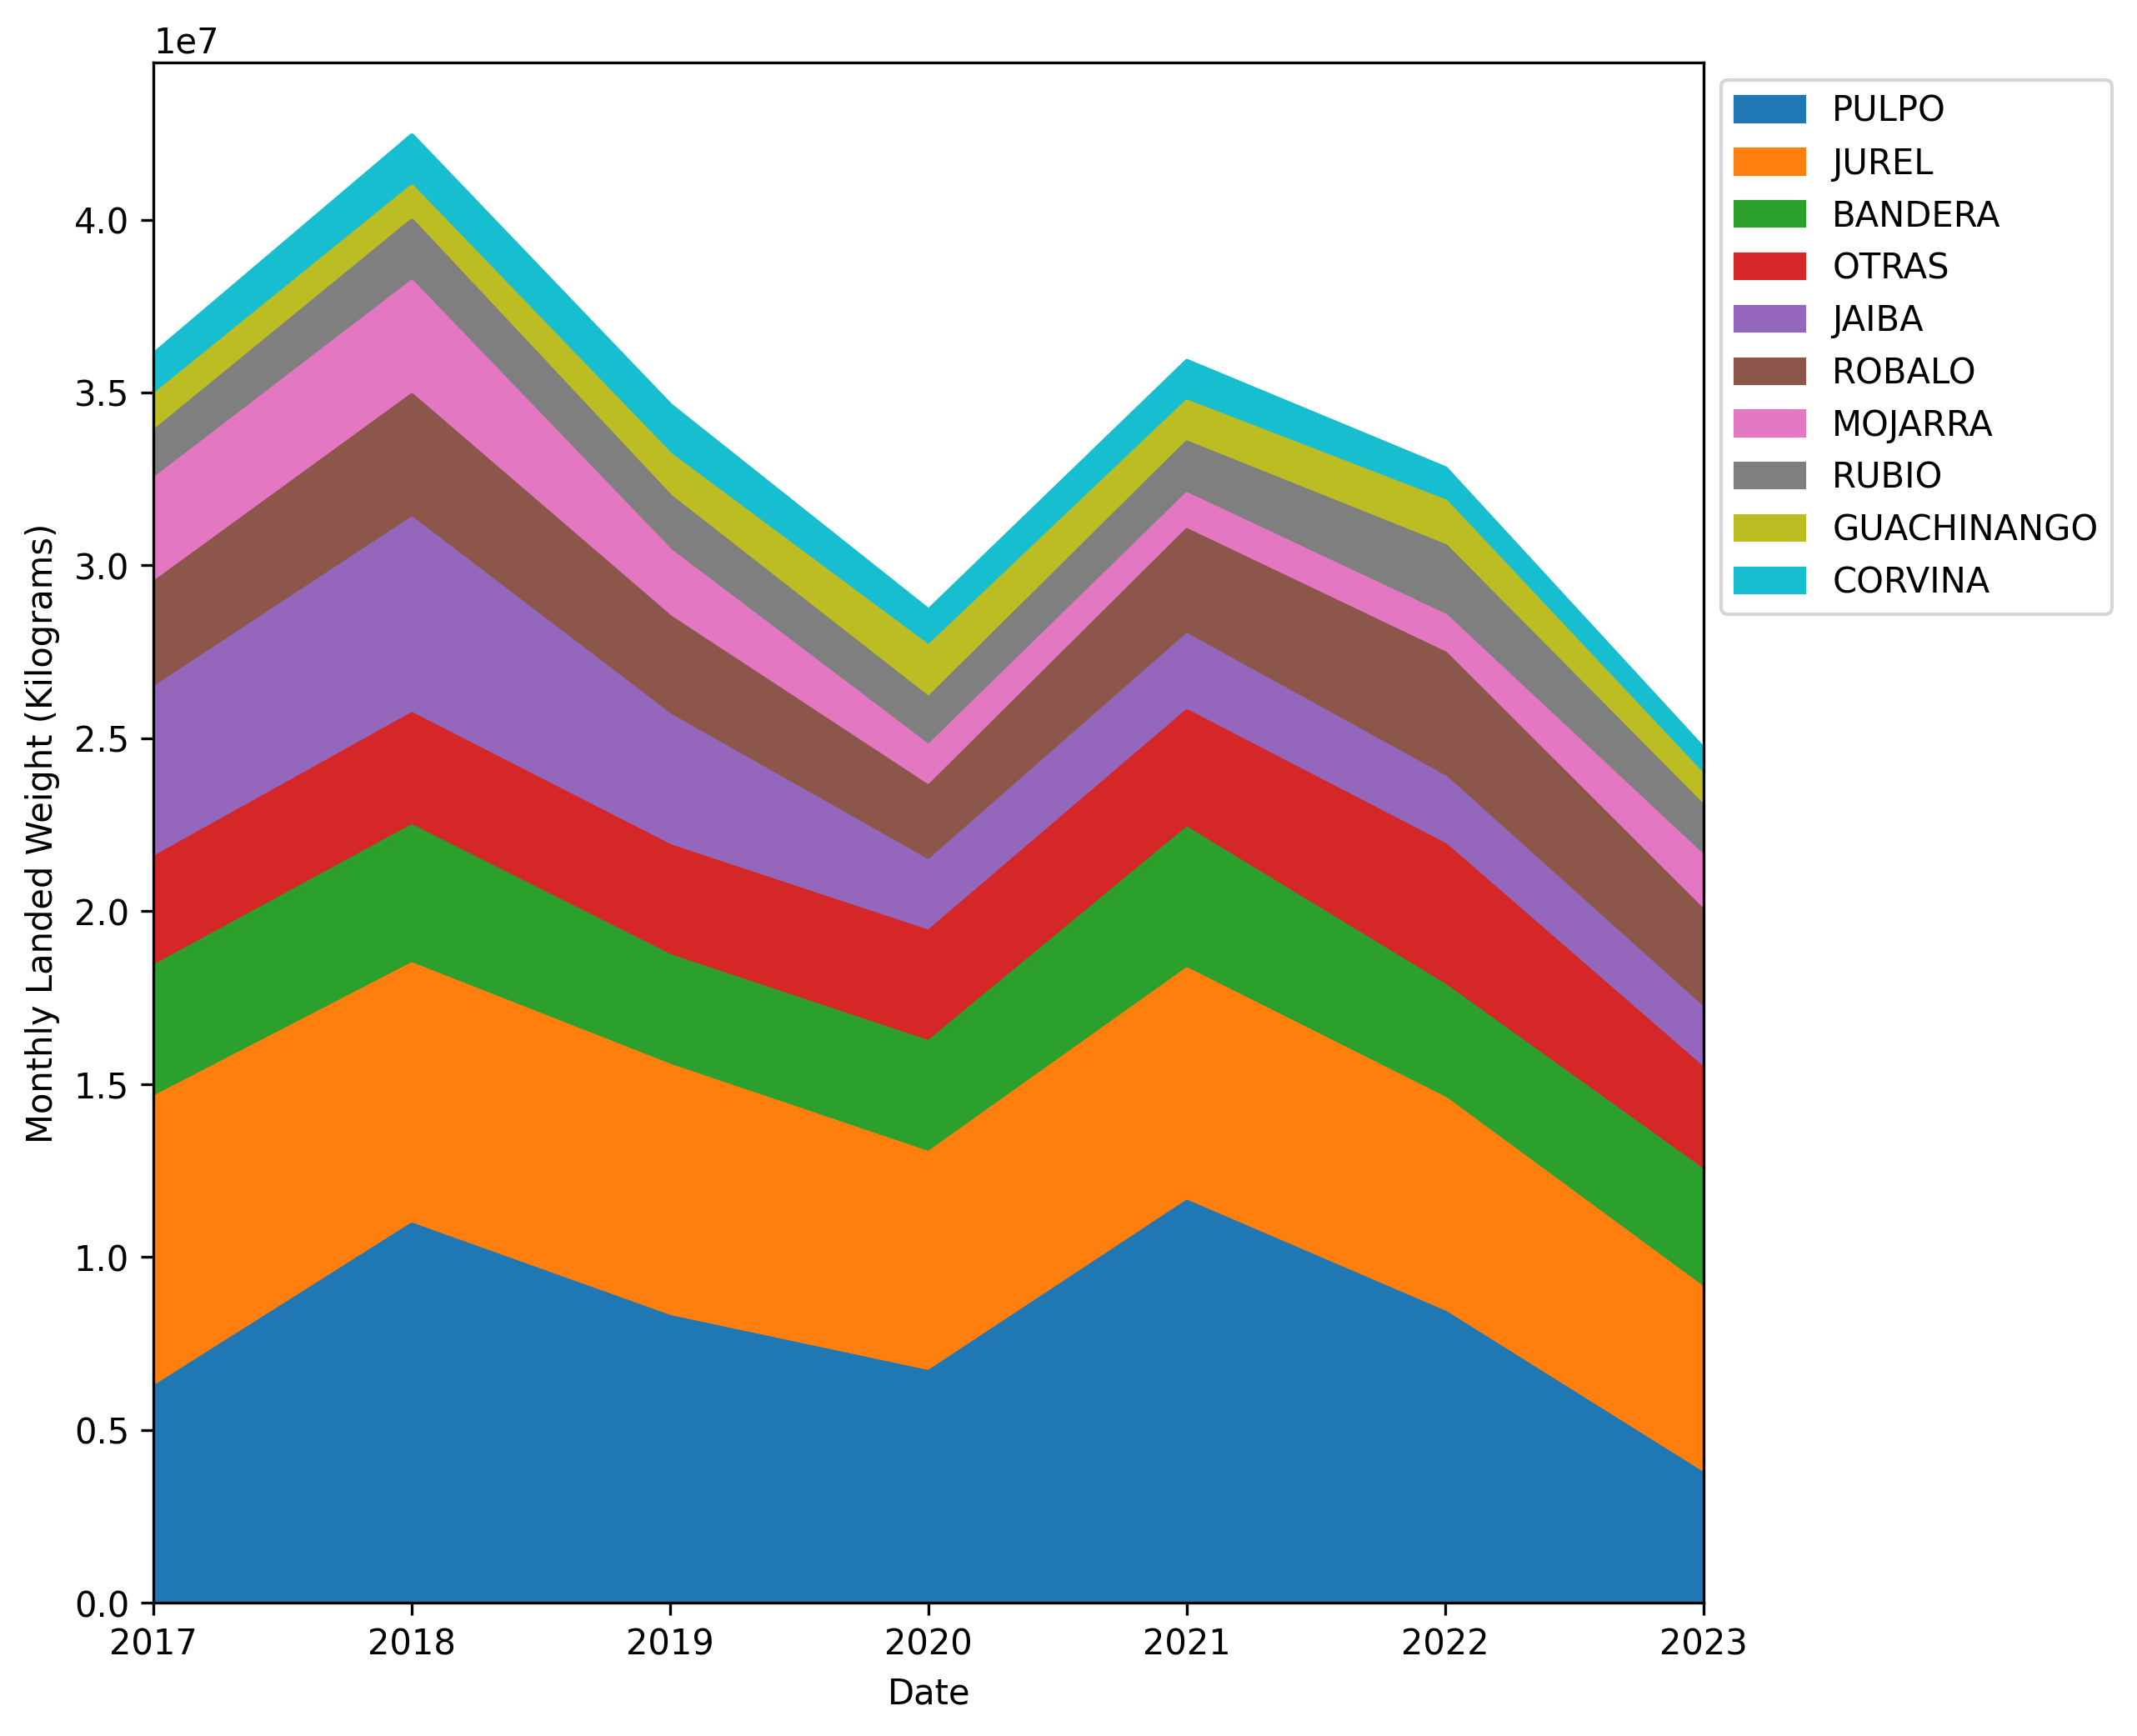

In [18]:


# Group by year, month, and species to get the monthly data
monthly_df = top_10_species_df.groupby([pd.Grouper(key='FECHA AVISO', freq='YE'), 'NOMBRE PRINCIPAL'])['PESO DESEMBARCADO_KILOGRAMOS'].sum().unstack().fillna(0)

# Sort the columns according to the total catch
ordered_columns = monthly_df.sum().sort_values(ascending=False).index
monthly_df = monthly_df[ordered_columns]

# Plot the monthly time series with stacked areas
plt.figure(figsize=(8, 8),dpi=300)
monthly_df.plot.area(stacked=True, ax=plt.gca())
#plt.title('Monthly Time Series of the Top 10 Species by Landed Weight')
plt.xlabel('Date')
plt.ylabel('Monthly Landed Weight (Kilograms)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

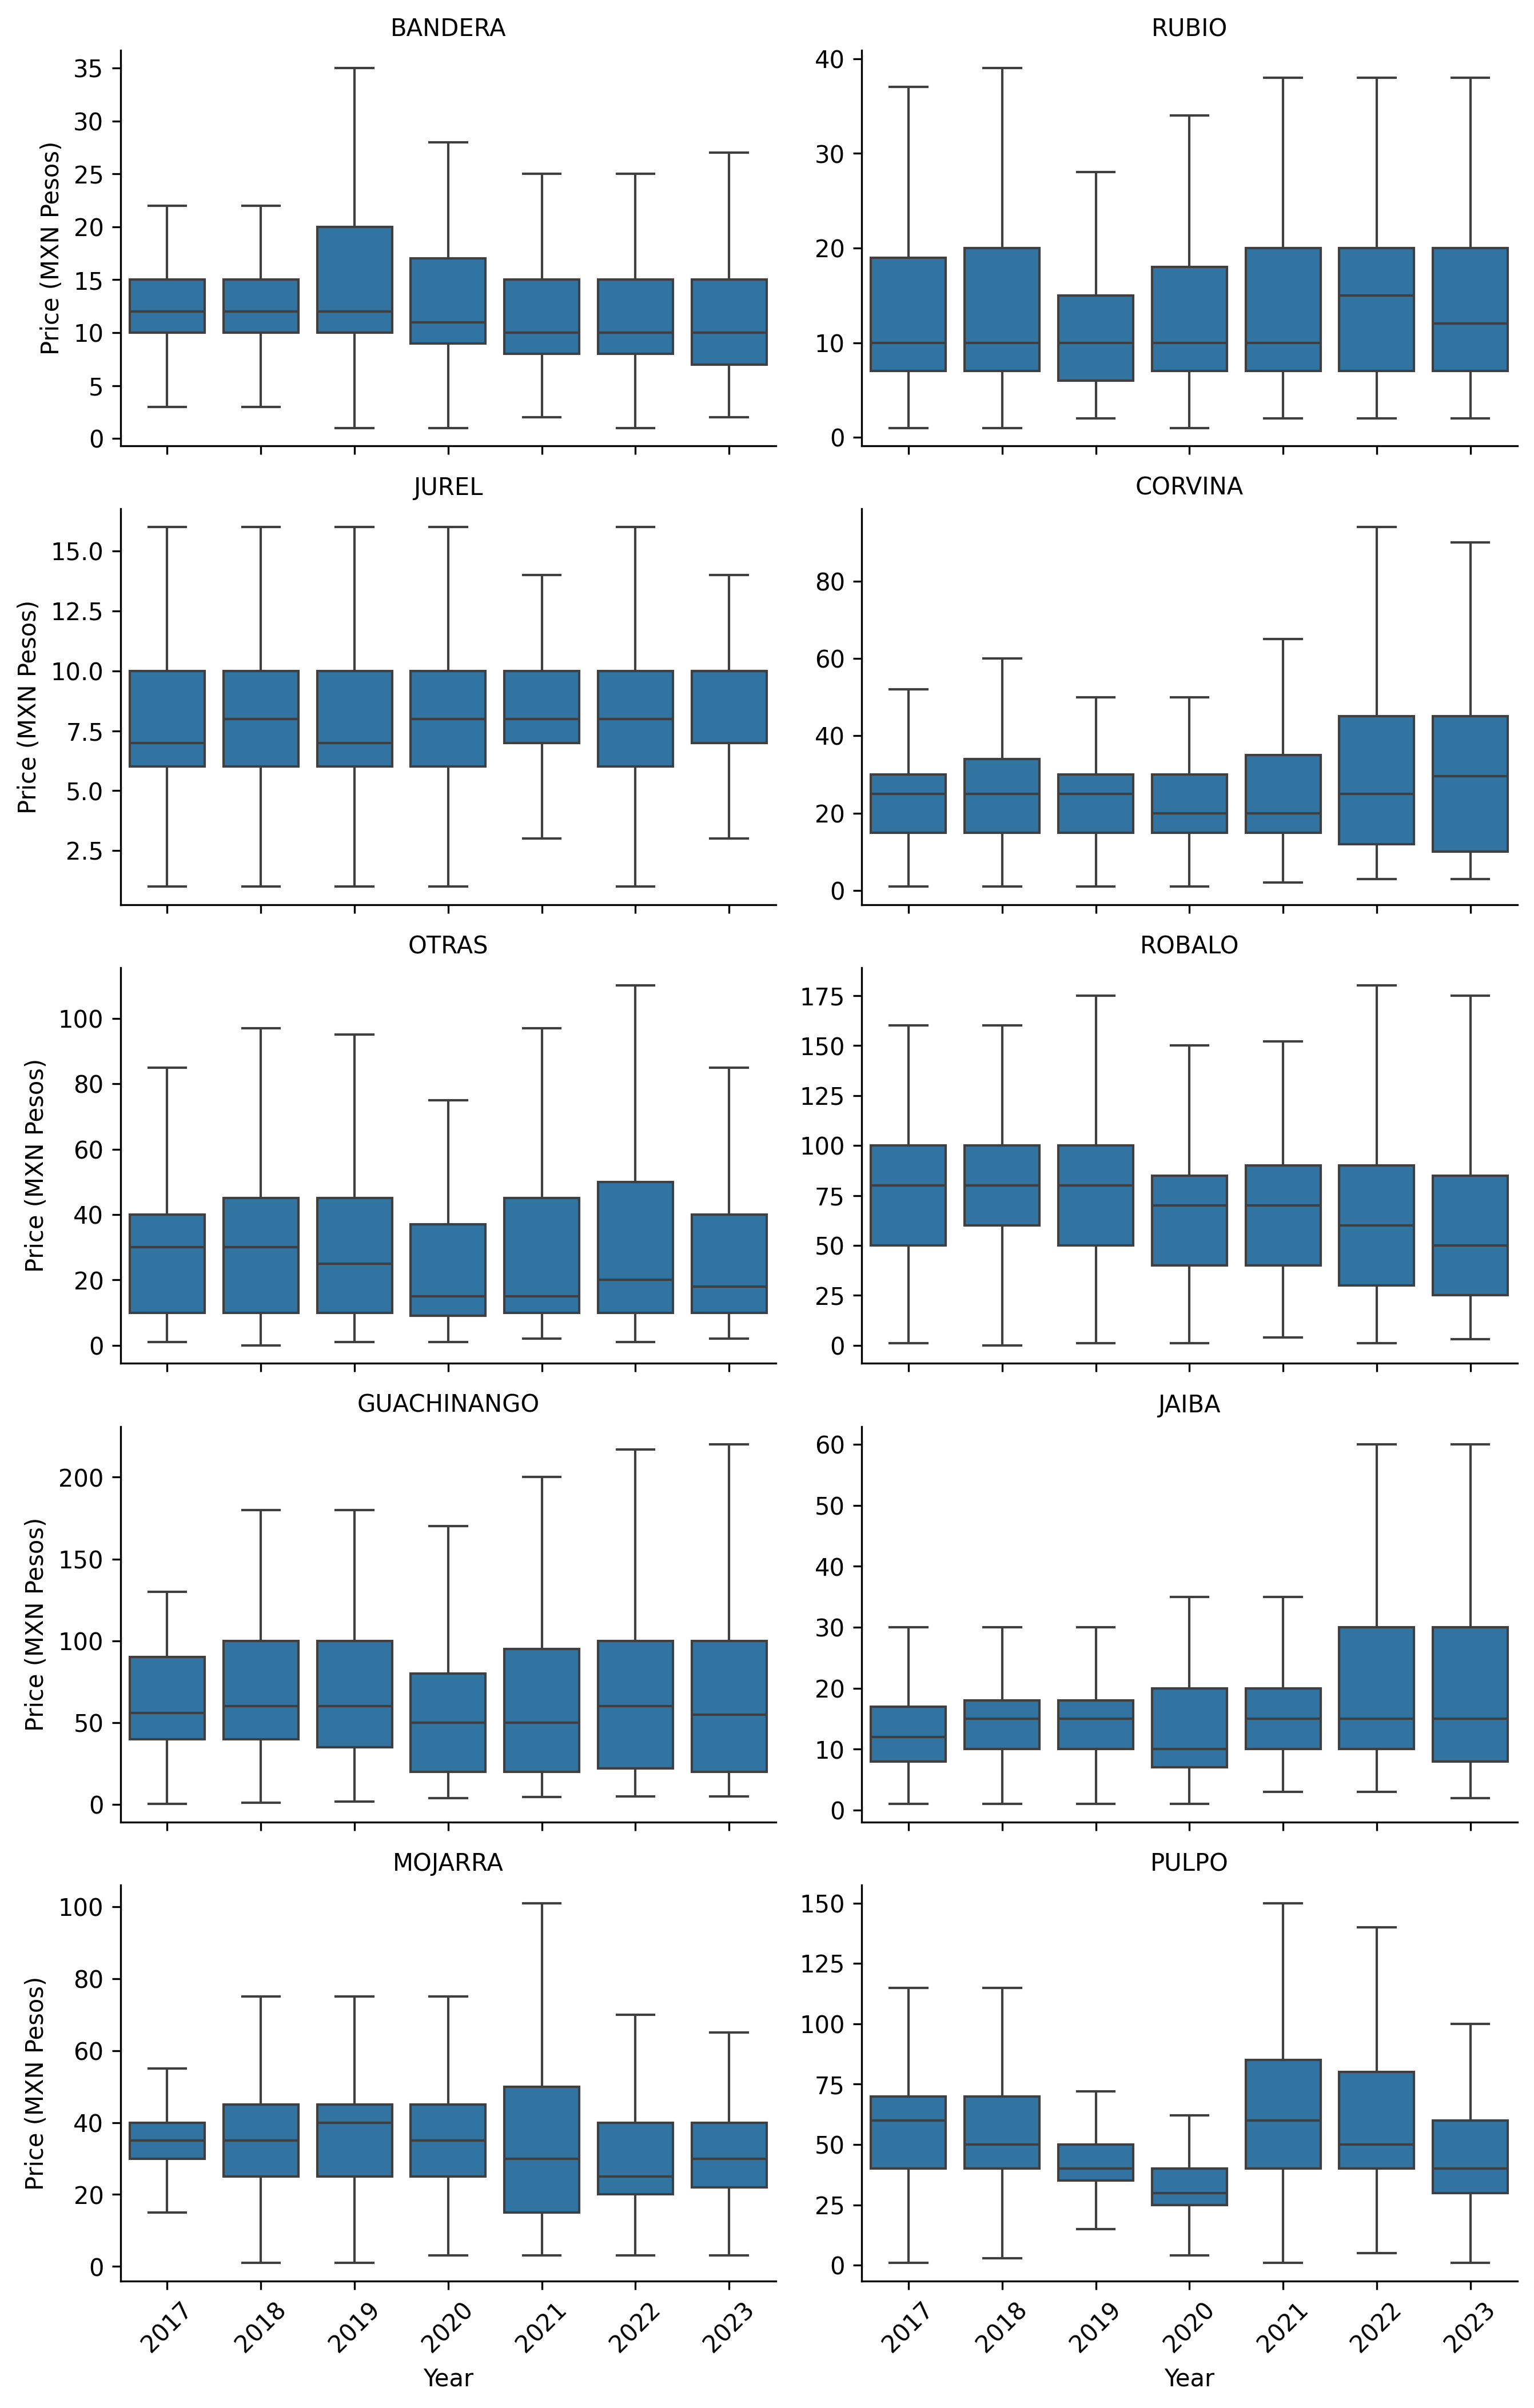

In [19]:

import seaborn as sns
# Filter data for the top 10 species by IIR
top_10_species_df = df[df['NOMBRE PRINCIPAL'].isin(iir_df['NOMBRE PRINCIPAL'].head(10))]

# Create a multi-panel boxplot for annual prices
g = sns.FacetGrid(top_10_species_df, col='NOMBRE PRINCIPAL', col_wrap=2, height=3, aspect=1.5, sharey=False)
g.map_dataframe(sns.boxplot, x='YEAR', y='PRECIO_PESOS', showfliers=False)
g.set_titles('{col_name}')
g.set_axis_labels('Year', 'Price (MXN Pesos)')
for ax in g.axes.flatten():
    for label in ax.get_xticklabels():
        label.set_rotation(45)
g.fig.tight_layout(w_pad=1)  # Adjust layout

# Add a main title
plt.subplots_adjust(top=0.92)
#g.fig.suptitle('Annual Price Distribution for Top 10 Species by IIR')
plt.gcf().set_dpi(300)
plt.show()

C:\Users\ricar\AppData\Local\Temp\ipykernel_18328\3304430722.py:48: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter([], [], c=scatter.cmap(cluster / (species_summary['Cluster'].max())), label=f'Cluster {cluster}')


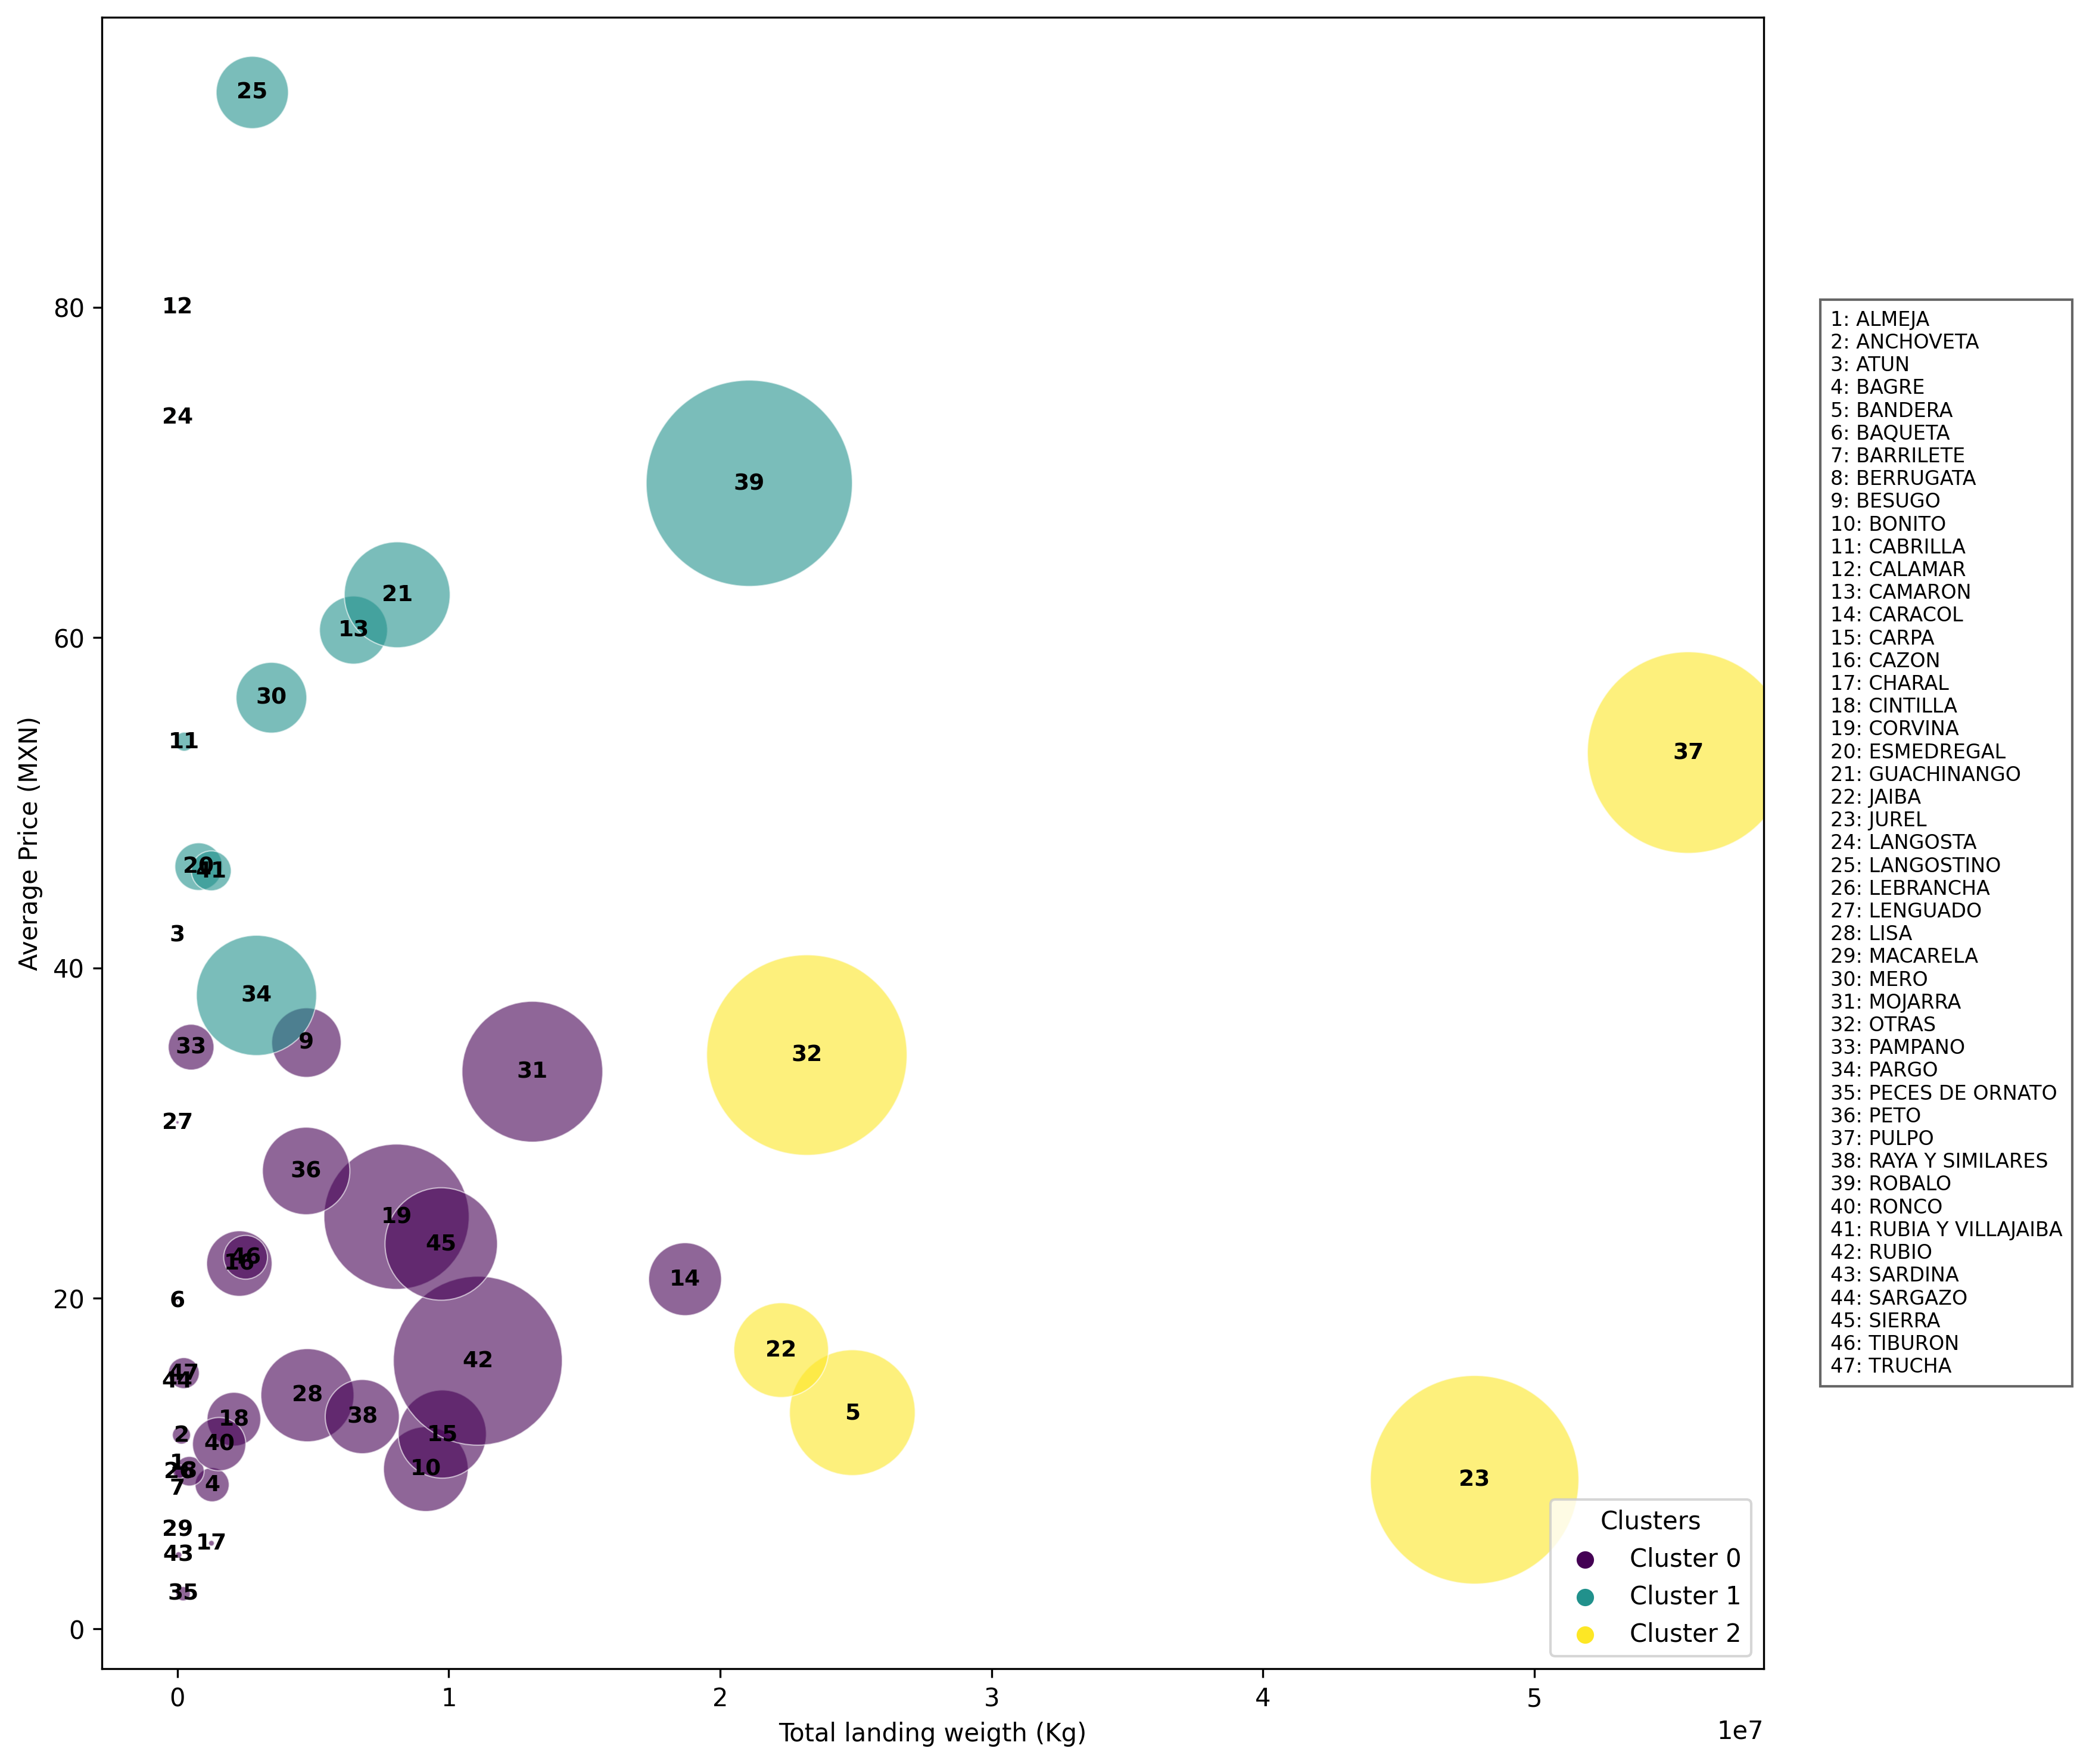

In [9]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


# Agrupar los datos por "Nombre Principal" para calcular los totales y el precio promedio
species_summary = df.groupby('NOMBRE PRINCIPAL').agg({
    'PESO DESEMBARCADO_KILOGRAMOS': 'sum',
    'PRECIO_PESOS': 'mean',
    'NOMBRE PRINCIPAL': 'count'
}).rename(columns={
    'PESO DESEMBARCADO_KILOGRAMOS': 'Total Peso Desembarcado (KG)',
    'PRECIO_PESOS': 'Precio Promedio (MXN)',
    'NOMBRE PRINCIPAL': 'Frecuencia de Registro'
}).reset_index()

# Asignar un código numérico a cada especie
species_codes = {species: i for i, species in enumerate(species_summary['NOMBRE PRINCIPAL'], 1)}
species_summary['Código'] = species_summary['NOMBRE PRINCIPAL'].map(species_codes)

# Realizar el análisis de clustering
X = species_summary[['Total Peso Desembarcado (KG)', 'Precio Promedio (MXN)']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=0)
species_summary['Cluster'] = kmeans.fit_predict(X_scaled)

# Crear la gráfica de dispersión
plt.figure(figsize=(12, 12),dpi=300)
scatter = plt.scatter(
    species_summary['Total Peso Desembarcado (KG)'],
    species_summary['Precio Promedio (MXN)'],
    c=species_summary['Cluster'],
    cmap='viridis',
    s=species_summary['Frecuencia de Registro'] /10,  # Ajustar el tamaño de los puntos según la frecuencia
    alpha=0.6,
    edgecolors='w',
    linewidth=0.5
)

# Añadir los códigos numéricos como etiquetas
for i, row in species_summary.iterrows():
    plt.text(row['Total Peso Desembarcado (KG)'], row['Precio Promedio (MXN)'], str(row['Código']),
             fontsize=9, ha='center', va='center', color='black', fontweight='bold')

# Añadir leyenda de los clusters
for cluster in species_summary['Cluster'].unique():
    plt.scatter([], [], c=scatter.cmap(cluster / (species_summary['Cluster'].max())), label=f'Cluster {cluster}')
plt.legend(title="Clusters", loc="lower right")

# Añadir la lista de especies con sus códigos como leyenda
legend_text = "\n".join([f"{code}: {species}" for species, code in species_codes.items()])
plt.gca().text(1.04, 0.5, legend_text, transform=plt.gca().transAxes, fontsize=8, verticalalignment='center', bbox=dict(facecolor='white', alpha=0.6))

# Añadir etiquetas y título
plt.xlabel('Total landing weigth (Kg)')
plt.ylabel('Average Price (MXN)')
#plt.title('Dispersión de Captura vs Precio con Tamaño de Frecuencia e Identificación de Clusters')
plt.show()

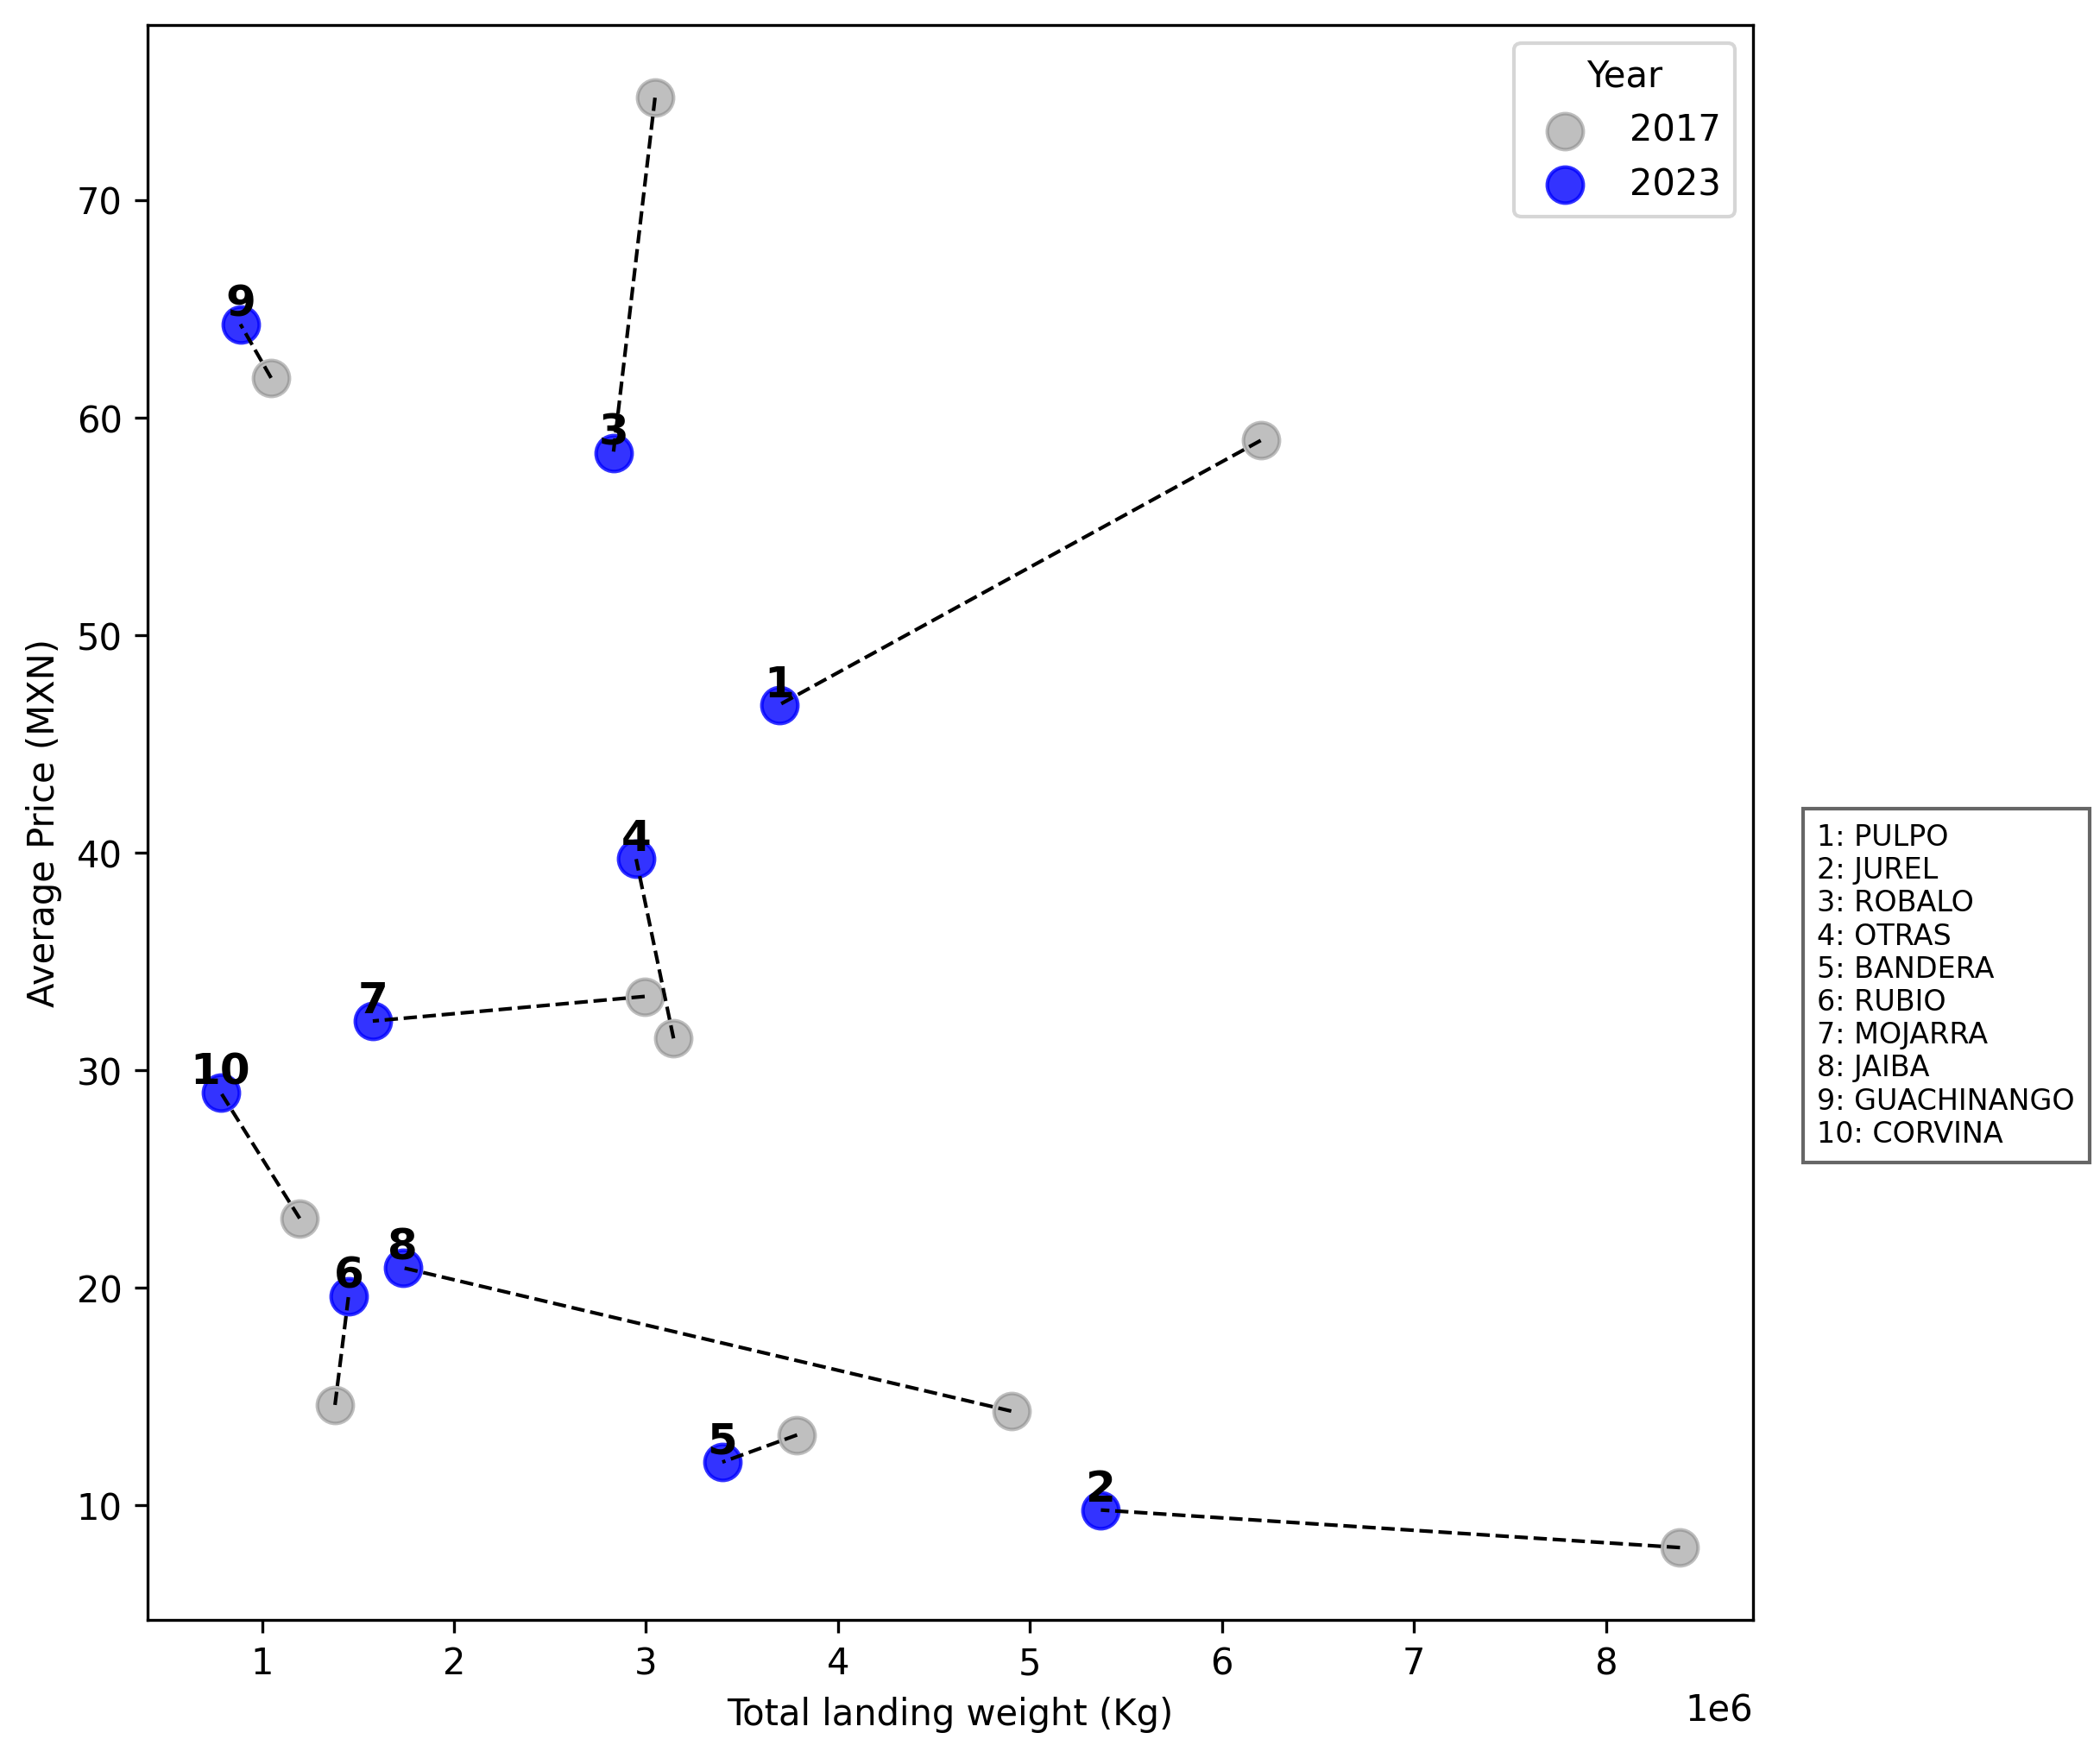

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('TABASCO_CAMPECHE_fishing_reports.csv', low_memory=False)

# Convert the date to datetime format and extract the year and month
df['FECHA AVISO'] = pd.to_datetime(df['FECHA AVISO'], format='%d/%m/%Y')
df['YEAR'] = df['FECHA AVISO'].dt.year
df['MONTH'] = df['FECHA AVISO'].dt.month

# Exclude the year 2016 and the species 'OSTION'
df = df[df['YEAR'] != 2016]
df = df[df['NOMBRE PRINCIPAL'] != 'OSTION']

# Correct the name of the office
df['NOMBRE OFICINA'] = df['NOMBRE OFICINA'].replace('SANCHEZ MAGALLANES', 'SANCHEZ MAGALLANEZ')

# Create a new column for the value of the catch
df['Value (MXN)'] = df['PESO DESEMBARCADO_KILOGRAMOS'] * df['PRECIO_PESOS']

# Calculate IIR for all species
species_summary = df.groupby('NOMBRE PRINCIPAL').agg({
    'PESO DESEMBARCADO_KILOGRAMOS': 'sum',
    'PRECIO_PESOS': 'mean',
    'NOMBRE PRINCIPAL': 'count'
}).rename(columns={
    'PESO DESEMBARCADO_KILOGRAMOS': 'Total Peso Desembarcado (KG)',
    'PRECIO_PESOS': 'Precio Promedio (MXN)',
    'NOMBRE PRINCIPAL': 'Frecuencia de Registro'
}).reset_index()

# Calculate IIR
percent_volume = (species_summary['Total Peso Desembarcado (KG)'] / species_summary['Total Peso Desembarcado (KG)'].sum()) * 100
percent_value = (species_summary['Precio Promedio (MXN)'] / species_summary['Precio Promedio (MXN)'].sum()) * 100
percent_frequency = (species_summary['Frecuencia de Registro'] / species_summary['Frecuencia de Registro'].sum()) * 100
species_summary['IIR'] = (percent_volume + percent_value + percent_frequency) / 3

# Filter top 10 species by IIR and assign labels 1 to 10
top_species_summary = species_summary.nlargest(10, 'IIR').reset_index(drop=True)
top_species_summary['Label'] = range(1, 11)

# Extract data for the years 2017 and 2023
data_2017 = df[(df['YEAR'] == 2017) & (df['NOMBRE PRINCIPAL'].isin(top_species_summary['NOMBRE PRINCIPAL']))]
data_2023 = df[(df['YEAR'] == 2023) & (df['NOMBRE PRINCIPAL'].isin(top_species_summary['NOMBRE PRINCIPAL']))]

# Calculate summary statistics for 2017 and 2023
summary_2017 = data_2017.groupby('NOMBRE PRINCIPAL').agg({
    'PESO DESEMBARCADO_KILOGRAMOS': 'sum',
    'PRECIO_PESOS': 'mean'
}).rename(columns={
    'PESO DESEMBARCADO_KILOGRAMOS': 'Total Peso Desembarcado (KG) 2017',
    'PRECIO_PESOS': 'Precio Promedio (MXN) 2017'
}).reset_index()

summary_2023 = data_2023.groupby('NOMBRE PRINCIPAL').agg({
    'PESO DESEMBARCADO_KILOGRAMOS': 'sum',
    'PRECIO_PESOS': 'mean'
}).rename(columns={
    'PESO DESEMBARCADO_KILOGRAMOS': 'Total Peso Desembarcado (KG) 2023',
    'PRECIO_PESOS': 'Precio Promedio (MXN) 2023'
}).reset_index()

# Merge 2017 and 2023 summaries
merged_summary = pd.merge(summary_2017, summary_2023, on='NOMBRE PRINCIPAL', suffixes=('_2017', '_2023'))
merged_summary = pd.merge(merged_summary, top_species_summary[['NOMBRE PRINCIPAL', 'Label']], on='NOMBRE PRINCIPAL')

# Plotting
plt.figure(figsize=(8, 8), dpi=300)

# Plot data points and lines for top 10 species
for i, row in merged_summary.iterrows():
    plt.scatter(row['Total Peso Desembarcado (KG) 2017'], row['Precio Promedio (MXN) 2017'], color='gray', alpha=0.5, marker='o', s=100, label='2017' if i == 0 else "")
    plt.scatter(row['Total Peso Desembarcado (KG) 2023'], row['Precio Promedio (MXN) 2023'], color='blue', alpha=0.8, marker='o', s=100, label='2023' if i == 0 else "")
    plt.plot([row['Total Peso Desembarcado (KG) 2017'], row['Total Peso Desembarcado (KG) 2023']], 
             [row['Precio Promedio (MXN) 2017'], row['Precio Promedio (MXN) 2023']], 
             'k--', lw=1)
    plt.text(row['Total Peso Desembarcado (KG) 2023'], row['Precio Promedio (MXN) 2023'], str(row['Label']),
             fontsize=12, ha='center', va='bottom', color='black', fontweight='bold')

# Add legend for years
plt.legend(title="Year", loc="upper right")

# Add species list with codes as a legend
legend_text = "\n".join([f"{row['Label']}: {row['NOMBRE PRINCIPAL']}" for i, row in top_species_summary.iterrows()])
plt.gca().text(1.04, 0.5, legend_text, transform=plt.gca().transAxes, fontsize=8, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.6))

# Add labels and title
plt.xlabel('Total landing weight (Kg)')
plt.ylabel('Average Price (MXN)')
#plt.title('Scatter Plot of Landing Weight vs. Average Price with Frequency Size and Species Identification')
plt.show()


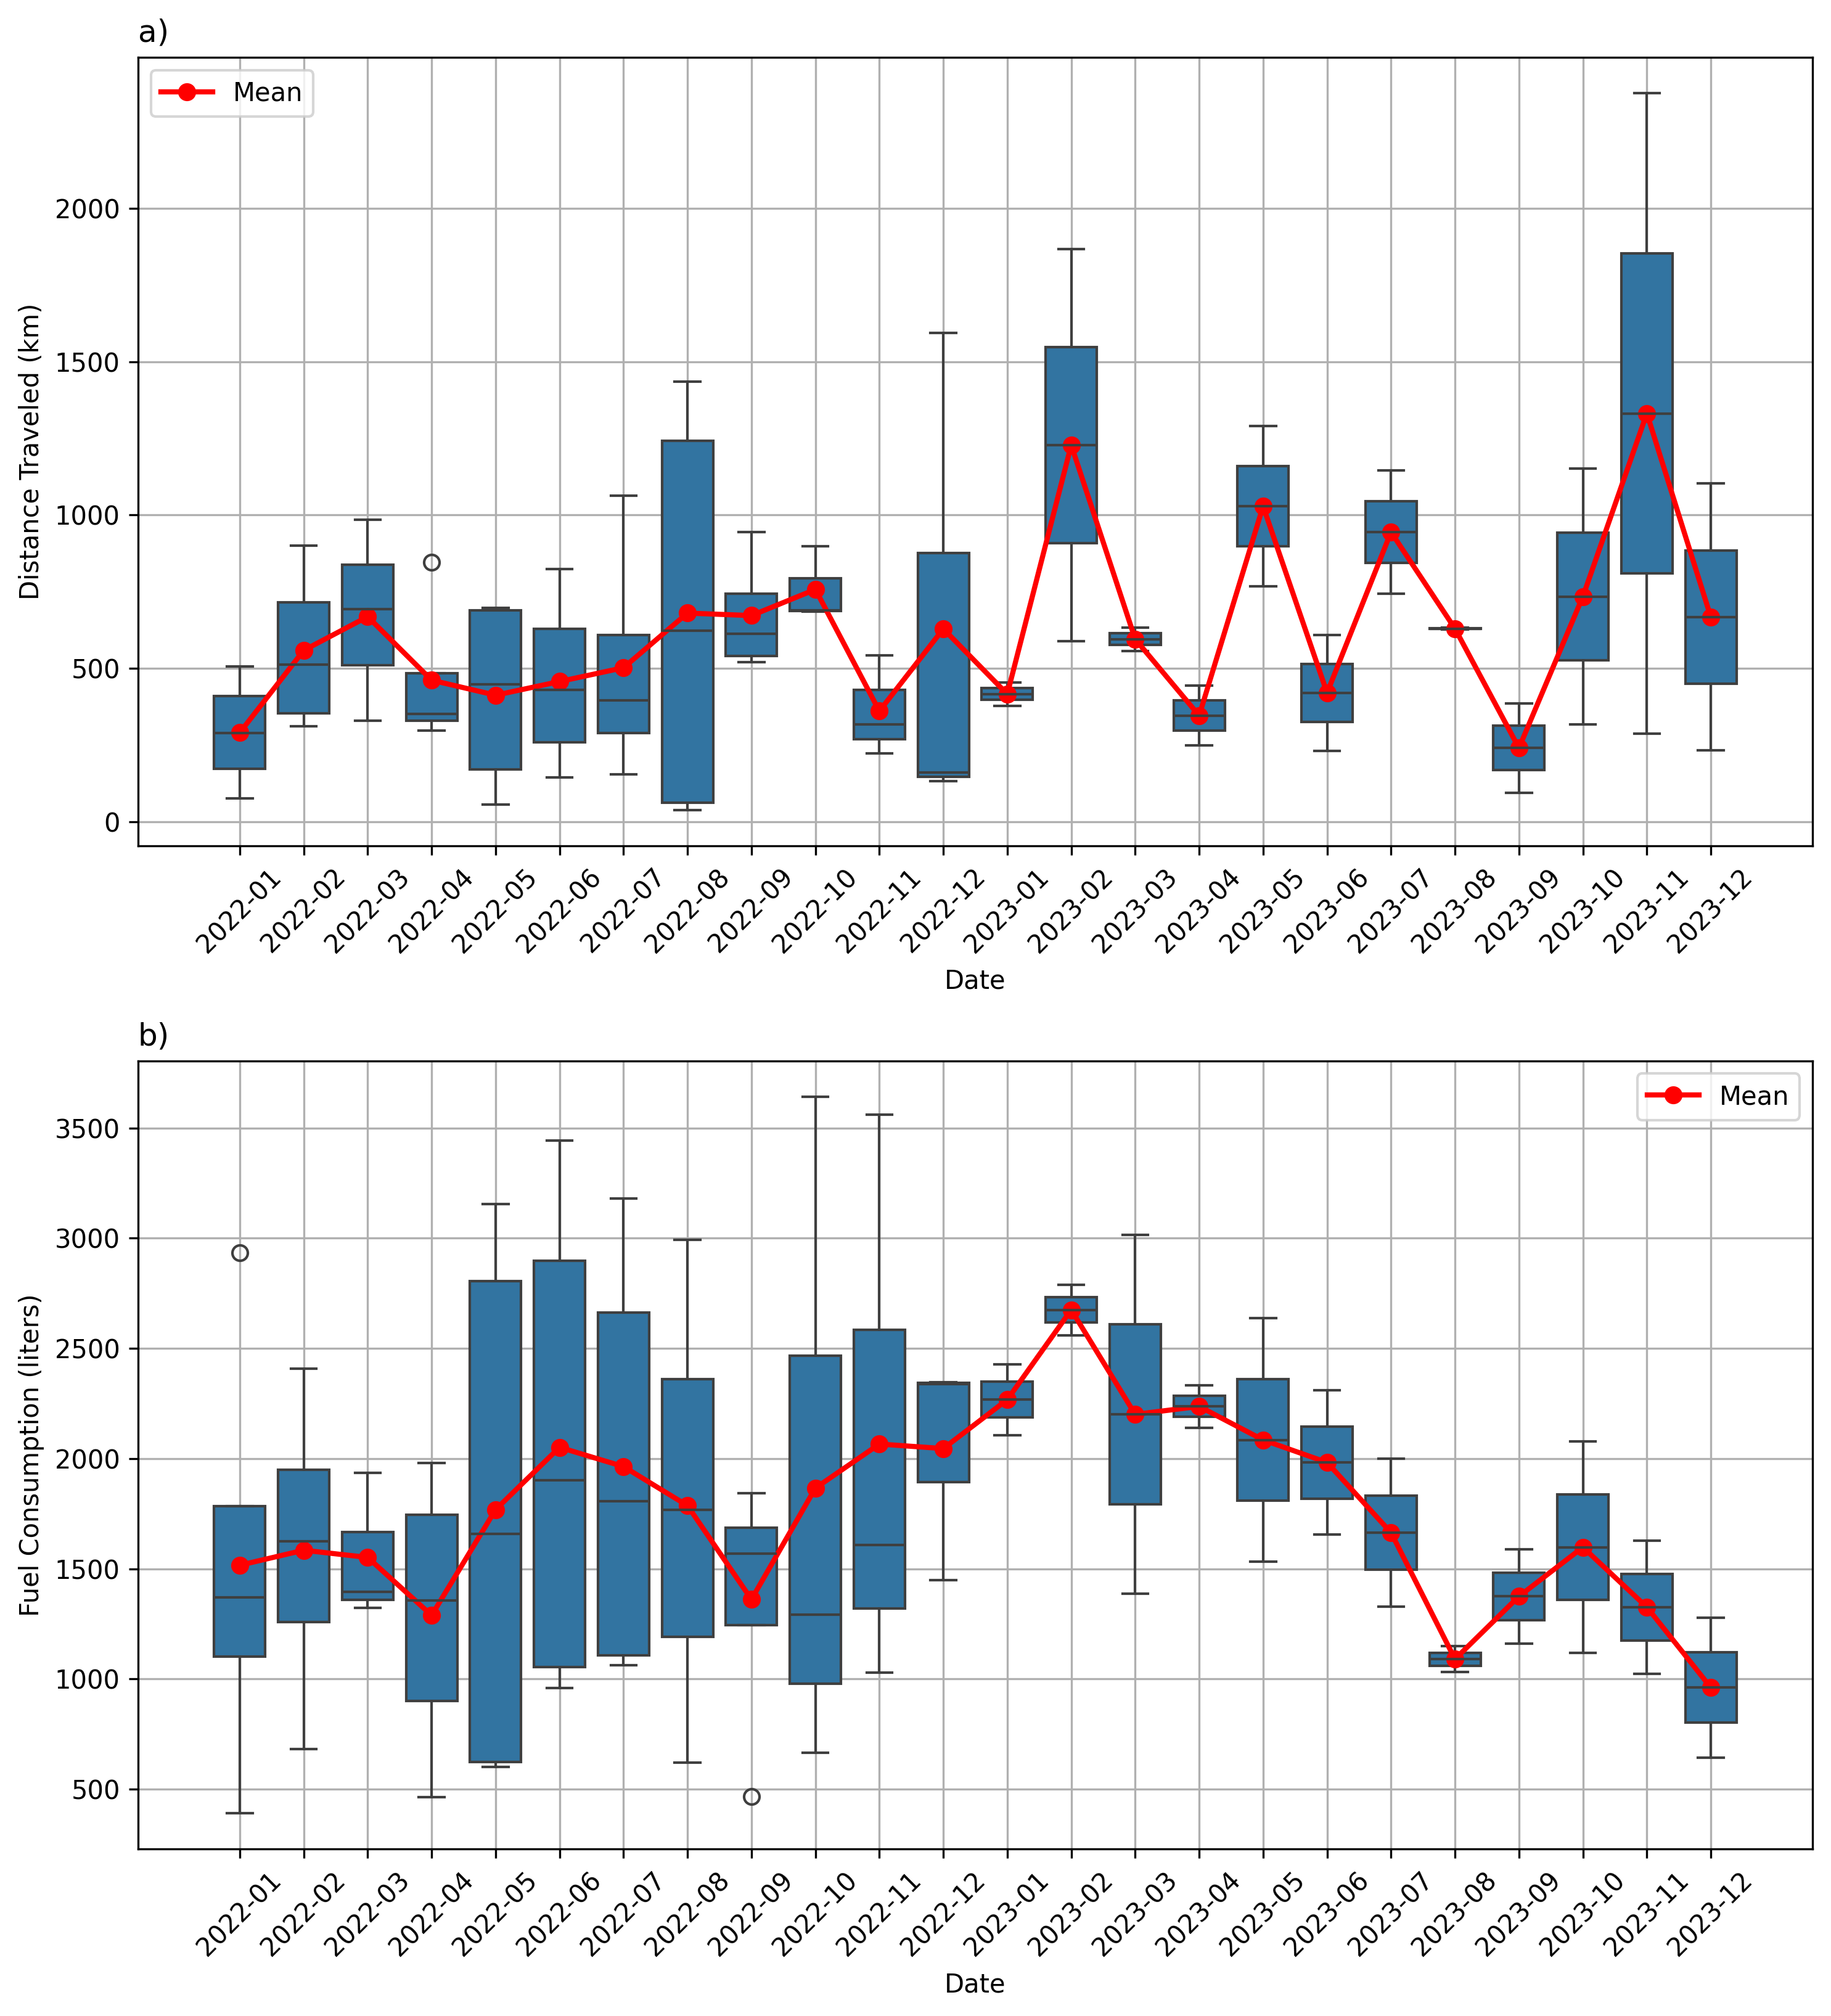

In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from geopy.distance import geodesic
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file
df = pd.read_csv('vms_flota_nemo.csv', low_memory=False)

# Convert date and time columns to datetime
df['Guardar_Marca'] = pd.to_datetime(df['Guardar_Marca'], errors='coerce')

# Filter points with speed equal to 0
df = df[df['Etapa_Viaje'] != 'Amarre']

# Sort the data by vessel and time
df = df.sort_values(by=['Nombre_Embarcacion', 'Guardar_Marca'])

# Create a geometry column from longitude and latitude columns
df['geometry'] = [Point(xy) for xy in zip(df.Longitud, df.Latitud)]
gdf = gpd.GeoDataFrame(df, geometry='geometry')

# Calculate the distance between consecutive points in time for each vessel
def calculate_distance(row):
    if pd.isnull(row['Latitud_prev']) or pd.isnull(row['Longitud_prev']):
        return 0
    return geodesic((row['Latitud'], row['Longitud']), (row['Latitud_prev'], row['Longitud_prev'])).km

# Shift the coordinates and time to get the previous point and time
gdf['Latitud_prev'] = gdf.groupby('Nombre_Embarcacion')['Latitud'].shift()
gdf['Longitud_prev'] = gdf.groupby('Nombre_Embarcacion')['Longitud'].shift()
gdf['Guardar_Marca_prev'] = gdf.groupby('Nombre_Embarcacion')['Guardar_Marca'].shift()

# Apply the distance calculation
gdf['Distancia_km'] = gdf.apply(calculate_distance, axis=1)

# Calculate the time difference in hours
gdf['Tiempo_horas'] = (gdf['Guardar_Marca'] - gdf['Guardar_Marca_prev']).dt.total_seconds() / 3600

# Replace NaN in distance and time columns with 0
gdf['Distancia_km'] = gdf['Distancia_km'].fillna(0)
gdf['Tiempo_horas'] = gdf['Tiempo_horas'].fillna(0)

# Calculate fuel consumption (liters) based on engine power and operation time

liters_per_hour = 36.9
# engine_power_hp = 100

gdf['Consumo_litros'] = gdf['Tiempo_horas'] * liters_per_hour
# Identify and remove outliers in fuel consumption
# Here, an outlier is defined as any value above the 99th percentile
q_upper = gdf['Consumo_litros'].quantile(0.99)
gdf = gdf[gdf['Consumo_litros'] <= q_upper]

# Create a year-month column
gdf['YearMonth'] = gdf['Guardar_Marca'].dt.to_period('M')

# Calculate the total distance traveled, fuel consumption, and hours at sea monthly for each vessel
monthly_distance_fuel = gdf.groupby(['Nombre_Embarcacion', 'YearMonth']).agg({
    'Distancia_km': 'sum',
    'Consumo_litros': 'sum',
    'Tiempo_horas': 'sum'
}).reset_index()

# Calculate the monthly averages of distance traveled, fuel consumption, and time at sea
mean_distance = monthly_distance_fuel.groupby('YearMonth')['Distancia_km'].mean()
mean_fuel = monthly_distance_fuel.groupby('YearMonth')['Consumo_litros'].mean()

# Plot the boxplots in a single figure
fig, axes = plt.subplots(2, 1, figsize=(10, 11), dpi=300)

# Plot a boxplot of the monthly distance traveled for all vessels
sns.boxplot(ax=axes[0], x='YearMonth', y='Distancia_km', data=monthly_distance_fuel)
axes[0].plot(mean_distance.index.astype(str), mean_distance.values, color='red', marker='o', linestyle='-', linewidth=2, label='Mean')
axes[0].set_title('a)', loc='left')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Distance Traveled (km)')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True)
axes[0].legend()

# Plot a boxplot of the monthly fuel consumption for all vessels
sns.boxplot(ax=axes[1], x='YearMonth', y='Consumo_litros', data=monthly_distance_fuel)
axes[1].plot(mean_fuel.index.astype(str), mean_fuel.values, color='red', marker='o', linestyle='-', linewidth=2, label='Mean')
axes[1].set_title('b)', loc='left')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Fuel Consumption (liters)')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True)
axes[1].legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()



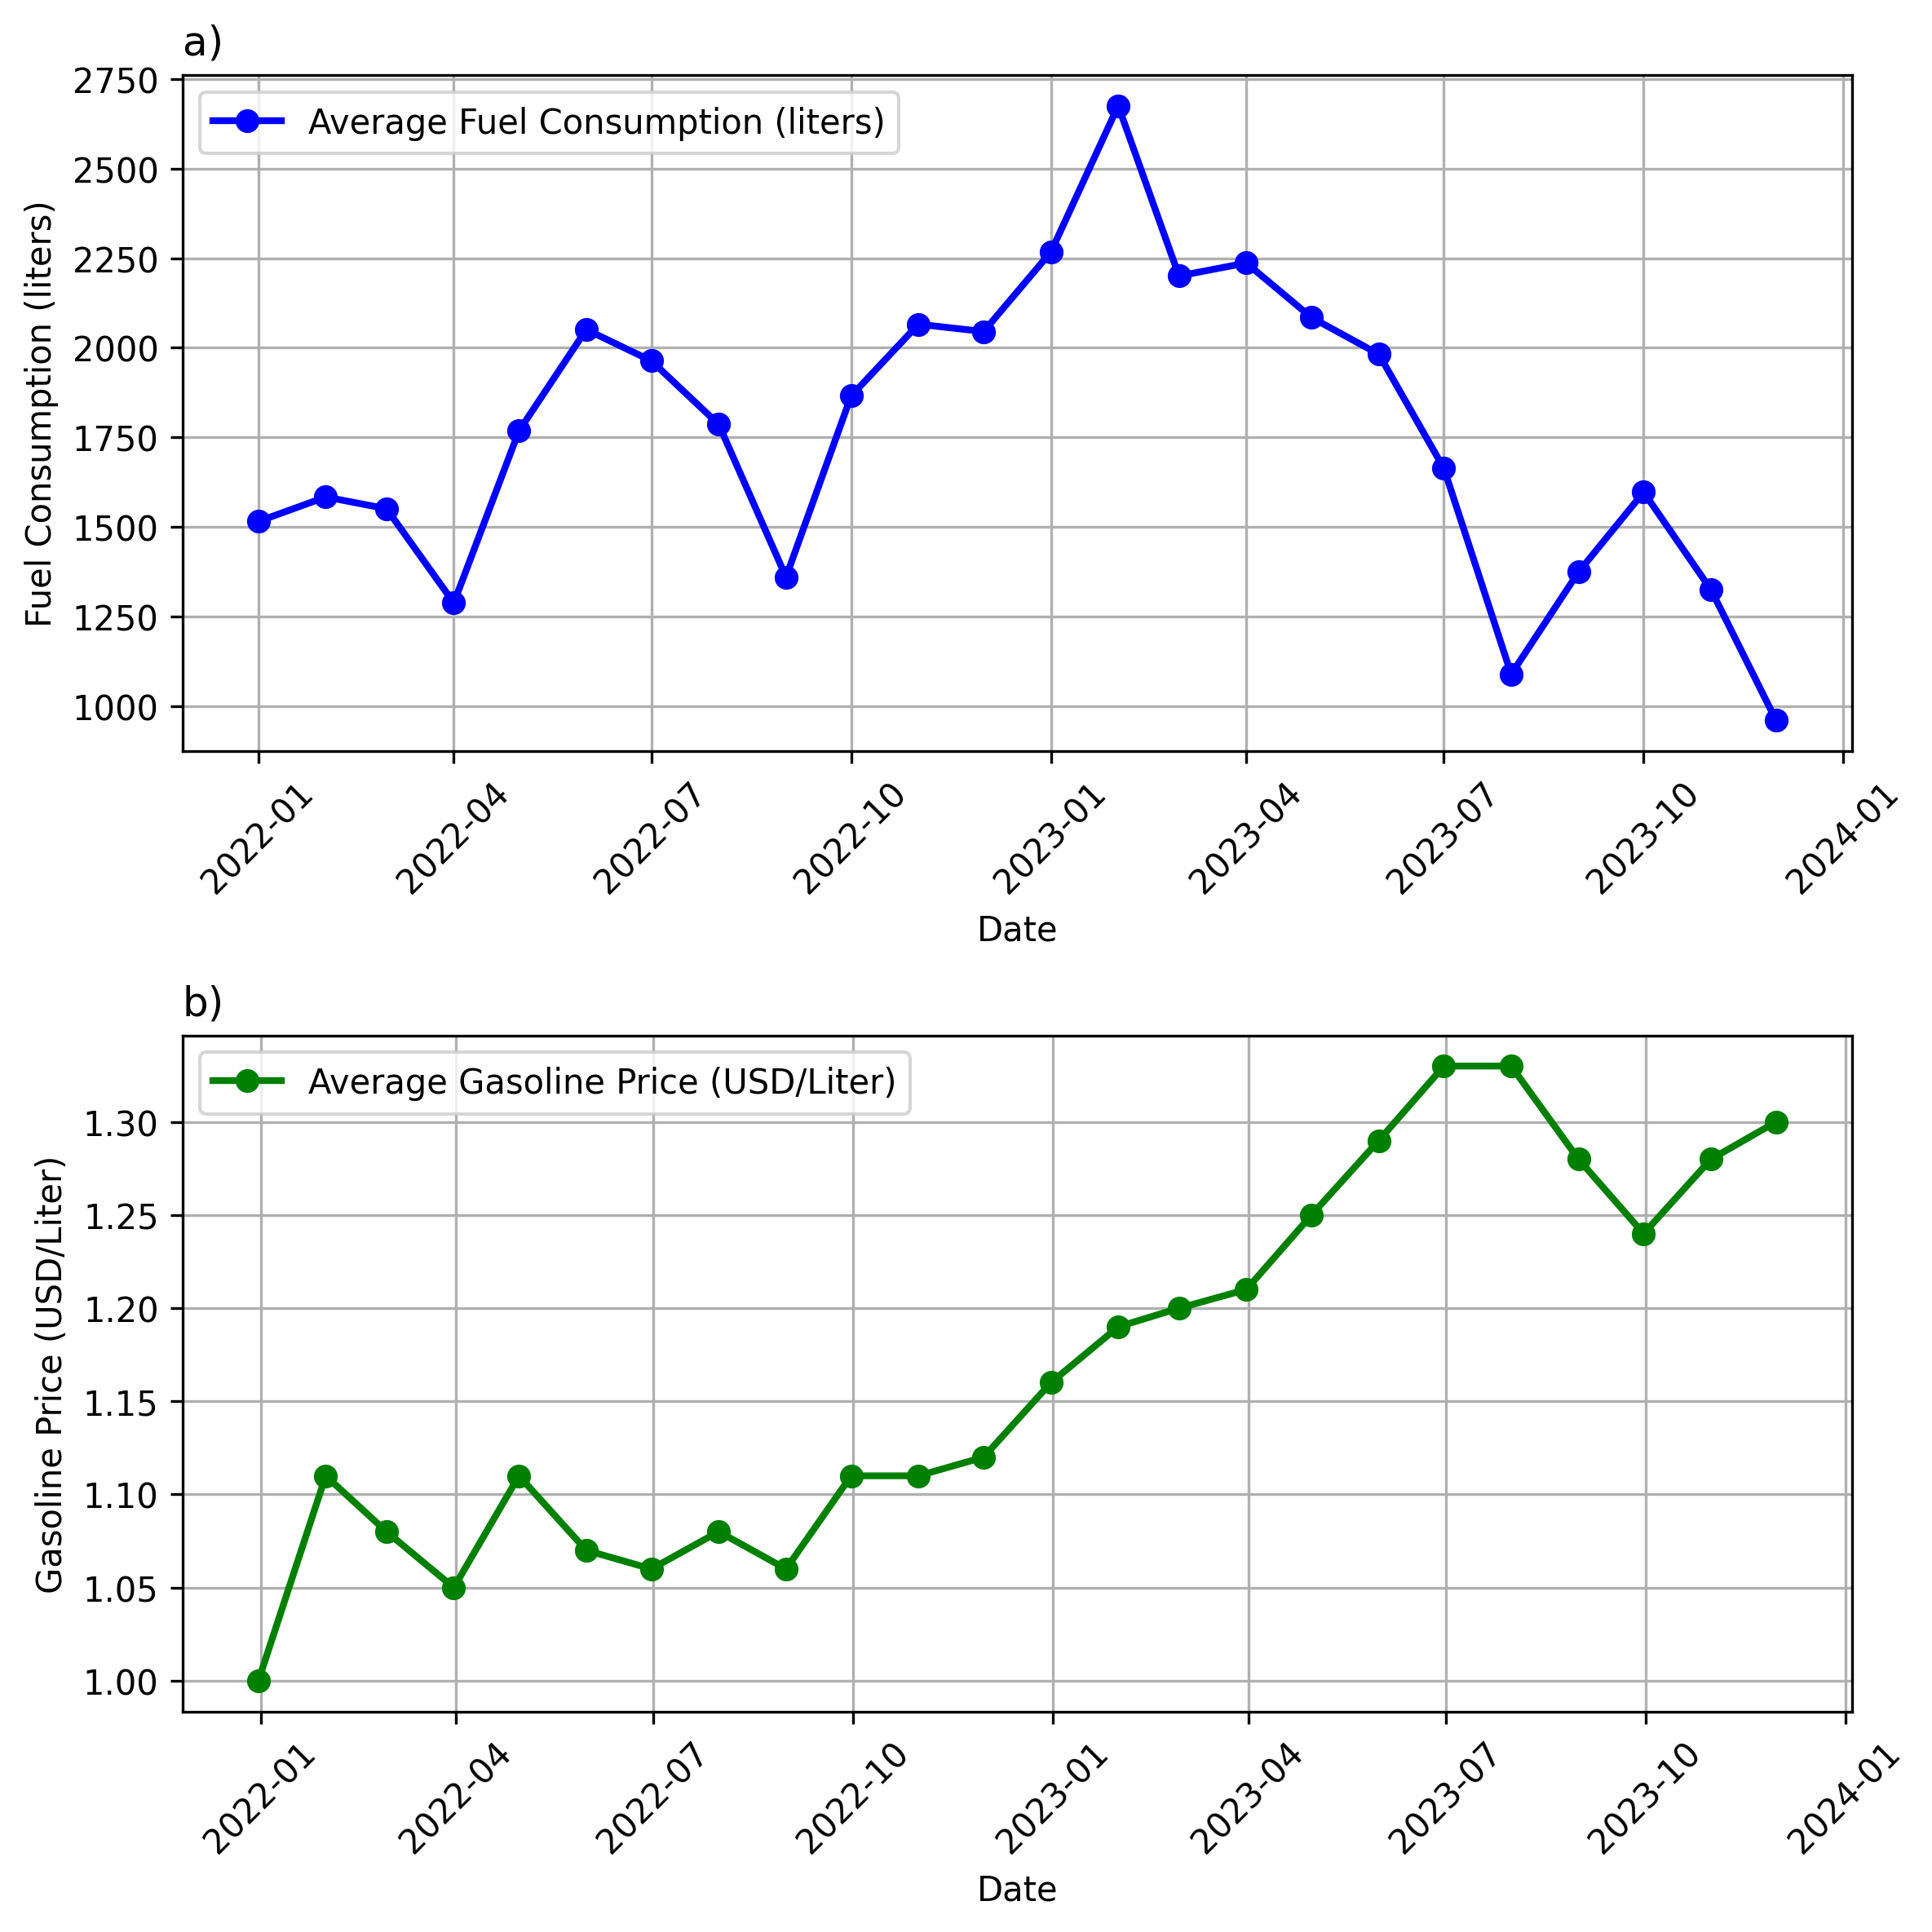

In [3]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from geopy.distance import geodesic
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar el archivo CSV
df_vms = pd.read_csv('vms_flota_nemo.csv', low_memory=False)

# Convertir las columnas de fecha y hora a datetime
df_vms['Guardar_Marca'] = pd.to_datetime(df_vms['Guardar_Marca'], errors='coerce')

# Filtrar los puntos con velocidad igual a 0
df_vms = df_vms[df_vms['Etapa_Viaje'] != 'Amarre']

# Ordenar los datos por embarcación y tiempo
df_vms = df_vms.sort_values(by=['Nombre_Embarcacion', 'Guardar_Marca'])

# Crear una columna de geometría a partir de las columnas de longitud y latitud
df_vms['geometry'] = [Point(xy) for xy in zip(df_vms.Longitud, df_vms.Latitud)]
gdf = gpd.GeoDataFrame(df_vms, geometry='geometry')

# Calcular la distancia entre puntos consecutivos en el tiempo para cada embarcación
def calculate_distance(row):
    if pd.isnull(row['Latitud_prev']) or pd.isnull(row['Longitud_prev']):
        return 0
    return geodesic((row['Latitud'], row['Longitud']), (row['Latitud_prev'], row['Longitud_prev'])).km

# Shift the coordinates and time to get the previous point and time
gdf['Latitud_prev'] = gdf.groupby('Nombre_Embarcacion')['Latitud'].shift()
gdf['Longitud_prev'] = gdf.groupby('Nombre_Embarcacion')['Longitud'].shift()
gdf['Guardar_Marca_prev'] = gdf.groupby('Nombre_Embarcacion')['Guardar_Marca'].shift()

# Apply the distance calculation
gdf['Distancia_km'] = gdf.apply(calculate_distance, axis=1)

# Calculate the time difference in hours
gdf['Tiempo_horas'] = (gdf['Guardar_Marca'] - gdf['Guardar_Marca_prev']).dt.total_seconds() / 3600

# Reemplazar NaN en las columnas de distancia y tiempo con 0
gdf['Distancia_km'] = gdf['Distancia_km'].fillna(0)
gdf['Tiempo_horas'] = gdf['Tiempo_horas'].fillna(0)

# Calcular el consumo de gasolina (litros) basado en la potencia del motor y el tiempo de operación

liters_per_houriters = 36.9

gdf['Consumo_litros'] = gdf['Tiempo_horas'] * liters_per_hour

# Identificar y eliminar valores anómalos en el consumo de gasolina
# Aquí, se define como anómalo cualquier valor que esté por encima del percentil 99
q_upper = gdf['Consumo_litros'].quantile(0.99)
gdf = gdf[gdf['Consumo_litros'] <= q_upper]

# Crear una columna de año-mes
gdf['YearMonth'] = gdf['Guardar_Marca'].dt.to_period('M').dt.to_timestamp()

# Calcular la distancia total recorrida, el consumo de gasolina y las horas en el mar mensualmente por cada embarcación
distancia_consumo_mensual = gdf.groupby(['Nombre_Embarcacion', 'YearMonth']).agg({
    'Distancia_km': 'sum',
    'Consumo_litros': 'sum',
    'Tiempo_horas': 'sum'
}).reset_index()

# Calcular las medias mensuales de distancia recorrida, consumo de gasolina y tiempo en el mar
medias_distancia = distancia_consumo_mensual.groupby('YearMonth')['Distancia_km'].mean()
medias_consumo = distancia_consumo_mensual.groupby('YearMonth')['Consumo_litros'].mean()
medias_tiempo = distancia_consumo_mensual.groupby('YearMonth')['Tiempo_horas'].mean()

# Datos del precio de la gasolina en México (USD/Litro)
data_gas = {
    'Date': pd.date_range(start='2021-12-01', periods=24, freq='ME'),
    'Price (USD/Liter)': [1.00, 1.11, 1.08, 1.05, 1.11, 1.07, 1.06, 1.08, 1.06, 1.11, 1.11, 1.12,
                          1.16, 1.19, 1.20, 1.21, 1.25, 1.29, 1.33, 1.33, 1.28, 1.24, 1.28, 1.30]
}

df_gas = pd.DataFrame(data_gas)

# Asegurar que las fechas coinciden exactamente
medias_consumo = medias_consumo.reset_index()
medias_consumo['YearMonth'] = pd.to_datetime(medias_consumo['YearMonth'])
df_gas['Date'] = pd.to_datetime(df_gas['Date'])

# Crear la figura y los ejes
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), dpi=300)

# Graficar el promedio de consumo de gasolina
ax1.plot(medias_consumo['YearMonth'], medias_consumo['Consumo_litros'], color='blue', marker='o', linestyle='-', linewidth=2, label='Average Fuel Consumption (liters)')
ax1.set_title('a)',loc='left')
ax1.set_xlabel('Date')
ax1.set_ylabel('Fuel Consumption (liters)')
ax1.legend(loc='upper left')
ax1.grid(True)
ax1.tick_params(axis='x', rotation=45)

# Graficar el precio promedio de la gasolina
ax2.plot(df_gas['Date'], df_gas['Price (USD/Liter)'], color='green', marker='o', linestyle='-', linewidth=2, label='Average Gasoline Price (USD/Liter)')
ax2.set_title('b)',loc='left')
ax2.set_xlabel('Date')
ax2.set_ylabel('Gasoline Price (USD/Liter)')
ax2.legend(loc='upper left')
ax2.grid(True)
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('AVISOS_MAYORES_2017_2023.csv',low_memory=True)

df = df[(df['NOMBRE ESTADO']=='TABASCO') | (df['NOMBRE ESTADO']=='CAMPECHE')]

# Convert the date to datetime format and extract the year and month
df['FECHA AVISO'] = pd.to_datetime(df['FECHA AVISO'], format='%d/%m/%Y')
df['YEAR'] = df['FECHA AVISO'].dt.year
df['MONTH'] = df['FECHA AVISO'].dt.month

# Exclude the year 2016 and the species 'OSTION'
df = df[df['YEAR'] != 2016]
df = df[df['NOMBRE PRINCIPAL'] != 'OSTION']

# Correct the name of the office
df['NOMBRE OFICINA'] = df['NOMBRE OFICINA'].replace('SANCHEZ MAGALLANES', 'SANCHEZ MAGALLANEZ')

In [8]:
# Create a new column for the value of the catch
df['Value (MXN)'] = df['PESO DESEMBARCADO_KILOGRAMOS'] * df['PRECIO_PESOS']

# 1. Identify the top 10 NOMBRE PRINCIPAL by their catch volume in PESO DESEMBARCADO_KILOGRAMOS
by_volume = df.groupby('NOMBRE PRINCIPAL')['PESO DESEMBARCADO_KILOGRAMOS'].sum()

# 2. Identify the top 10 NOMBRE PRINCIPAL by the value of the catch
by_value = df.groupby('NOMBRE PRINCIPAL')['Value (MXN)'].sum()

# 3. Identify the frequency with which each NOMBRE PRINCIPAL of the top 10 by volume is reported
by_frequency = df[df['NOMBRE PRINCIPAL'].isin(by_volume.index)]['NOMBRE PRINCIPAL'].value_counts()

# Calculate the percentage of catch, value, and frequency
total_volume = df['PESO DESEMBARCADO_KILOGRAMOS'].sum()
total_value = df['Value (MXN)'].sum()
total_reports = len(df)

percent_volume = by_volume / total_volume * 100
percent_value = by_value / total_value * 100
percent_frequency = by_frequency / total_reports * 100

# Create a DataFrame for the percentages
iir_df = pd.DataFrame({
    'NOMBRE PRINCIPAL': by_volume.index,
    '% Capture': percent_volume.values,
    '% Value': percent_value.reindex(by_volume.index).values,
    '% Frequency': percent_frequency.reindex(by_volume.index).values
})

# Calculate the Relative Importance Index (IIR)
iir_df['IIR'] = (iir_df['% Capture'] + iir_df['% Value'] + iir_df['% Frequency']) / 3

# Sort by IIR in descending order
iir_df = iir_df.sort_values(by='IIR', ascending=False)

# Filter data for the top 10 species by IIR
top_10_species_df = df[df['NOMBRE PRINCIPAL'].isin(iir_df['NOMBRE PRINCIPAL'].head(10))]
# Display the final table
iir_df[:10]

,NOMBRE PRINCIPAL,% Capture,% Value,% Frequency,IIR
7,CAMARON,72.259960,9.981032,42.843704,41.694898
17,OTRAS,2.105714,88.231687,5.093401,31.810267
13,GUACHINANGO,3.694393,0.515621,8.627873,4.279295
11,ESMEDREGAL,5.325010,0.359821,7.115979,4.266937
12,FAUNA,1.754905,0.013360,9.313264,3.693843
16,MERO,2.544270,0.270107,5.718317,2.844231
3,BESUGO,2.412384,0.148821,5.207633,2.589613
18,PARGO,1.191373,0.112457,4.213143,1.838991
2,BANDERA,2.775448,0.061829,2.029297,1.622191
24,RUBIA Y VILLAJAIBA,0.920578,0.061253,3.346324,1.442718


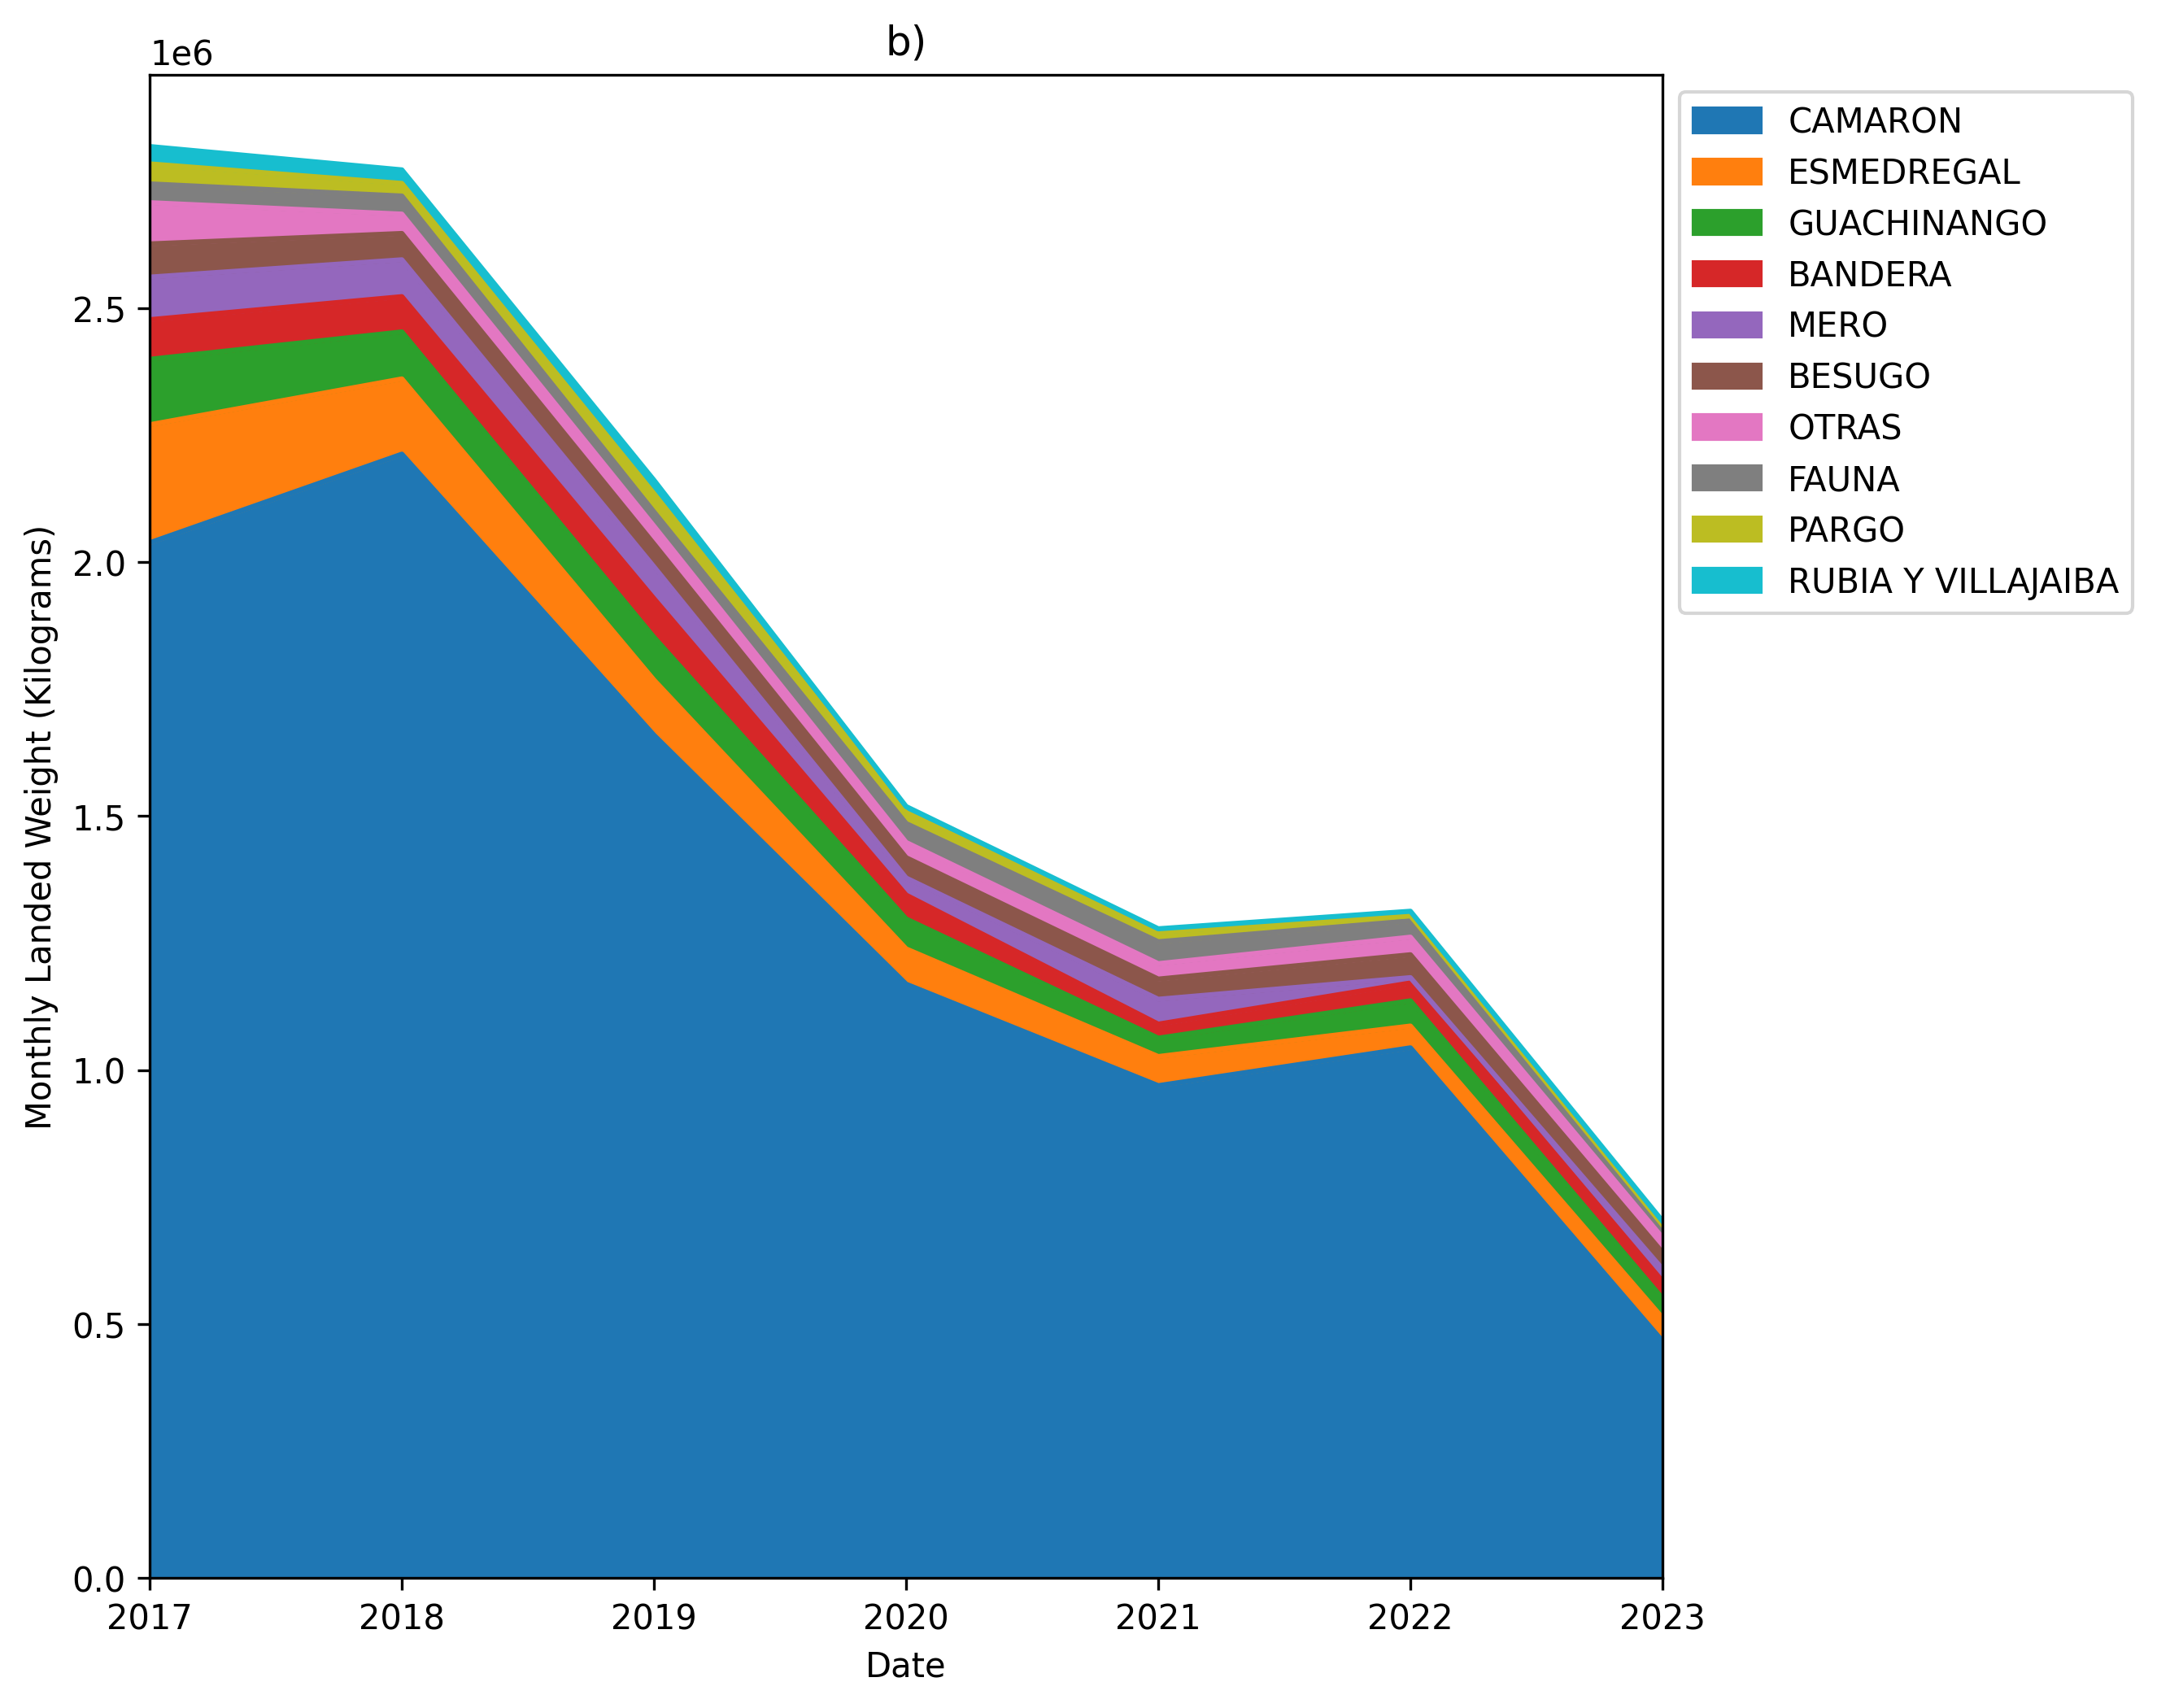

In [17]:
# Group by year, month, and species to get the monthly data
monthly_df = top_10_species_df.groupby([pd.Grouper(key='FECHA AVISO', freq='YE'), 'NOMBRE PRINCIPAL'])['PESO DESEMBARCADO_KILOGRAMOS'].sum().unstack().fillna(0)

# Sort the columns according to the total catch
ordered_columns = monthly_df.sum().sort_values(ascending=False).index
monthly_df = monthly_df[ordered_columns]

# Plot the monthly time series with stacked areas
plt.figure(figsize=(8, 8),dpi=300)
monthly_df.plot.area(stacked=True, ax=plt.gca())
plt.title('b)')
plt.xlabel('Date')
plt.ylabel('Monthly Landed Weight (Kilograms)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

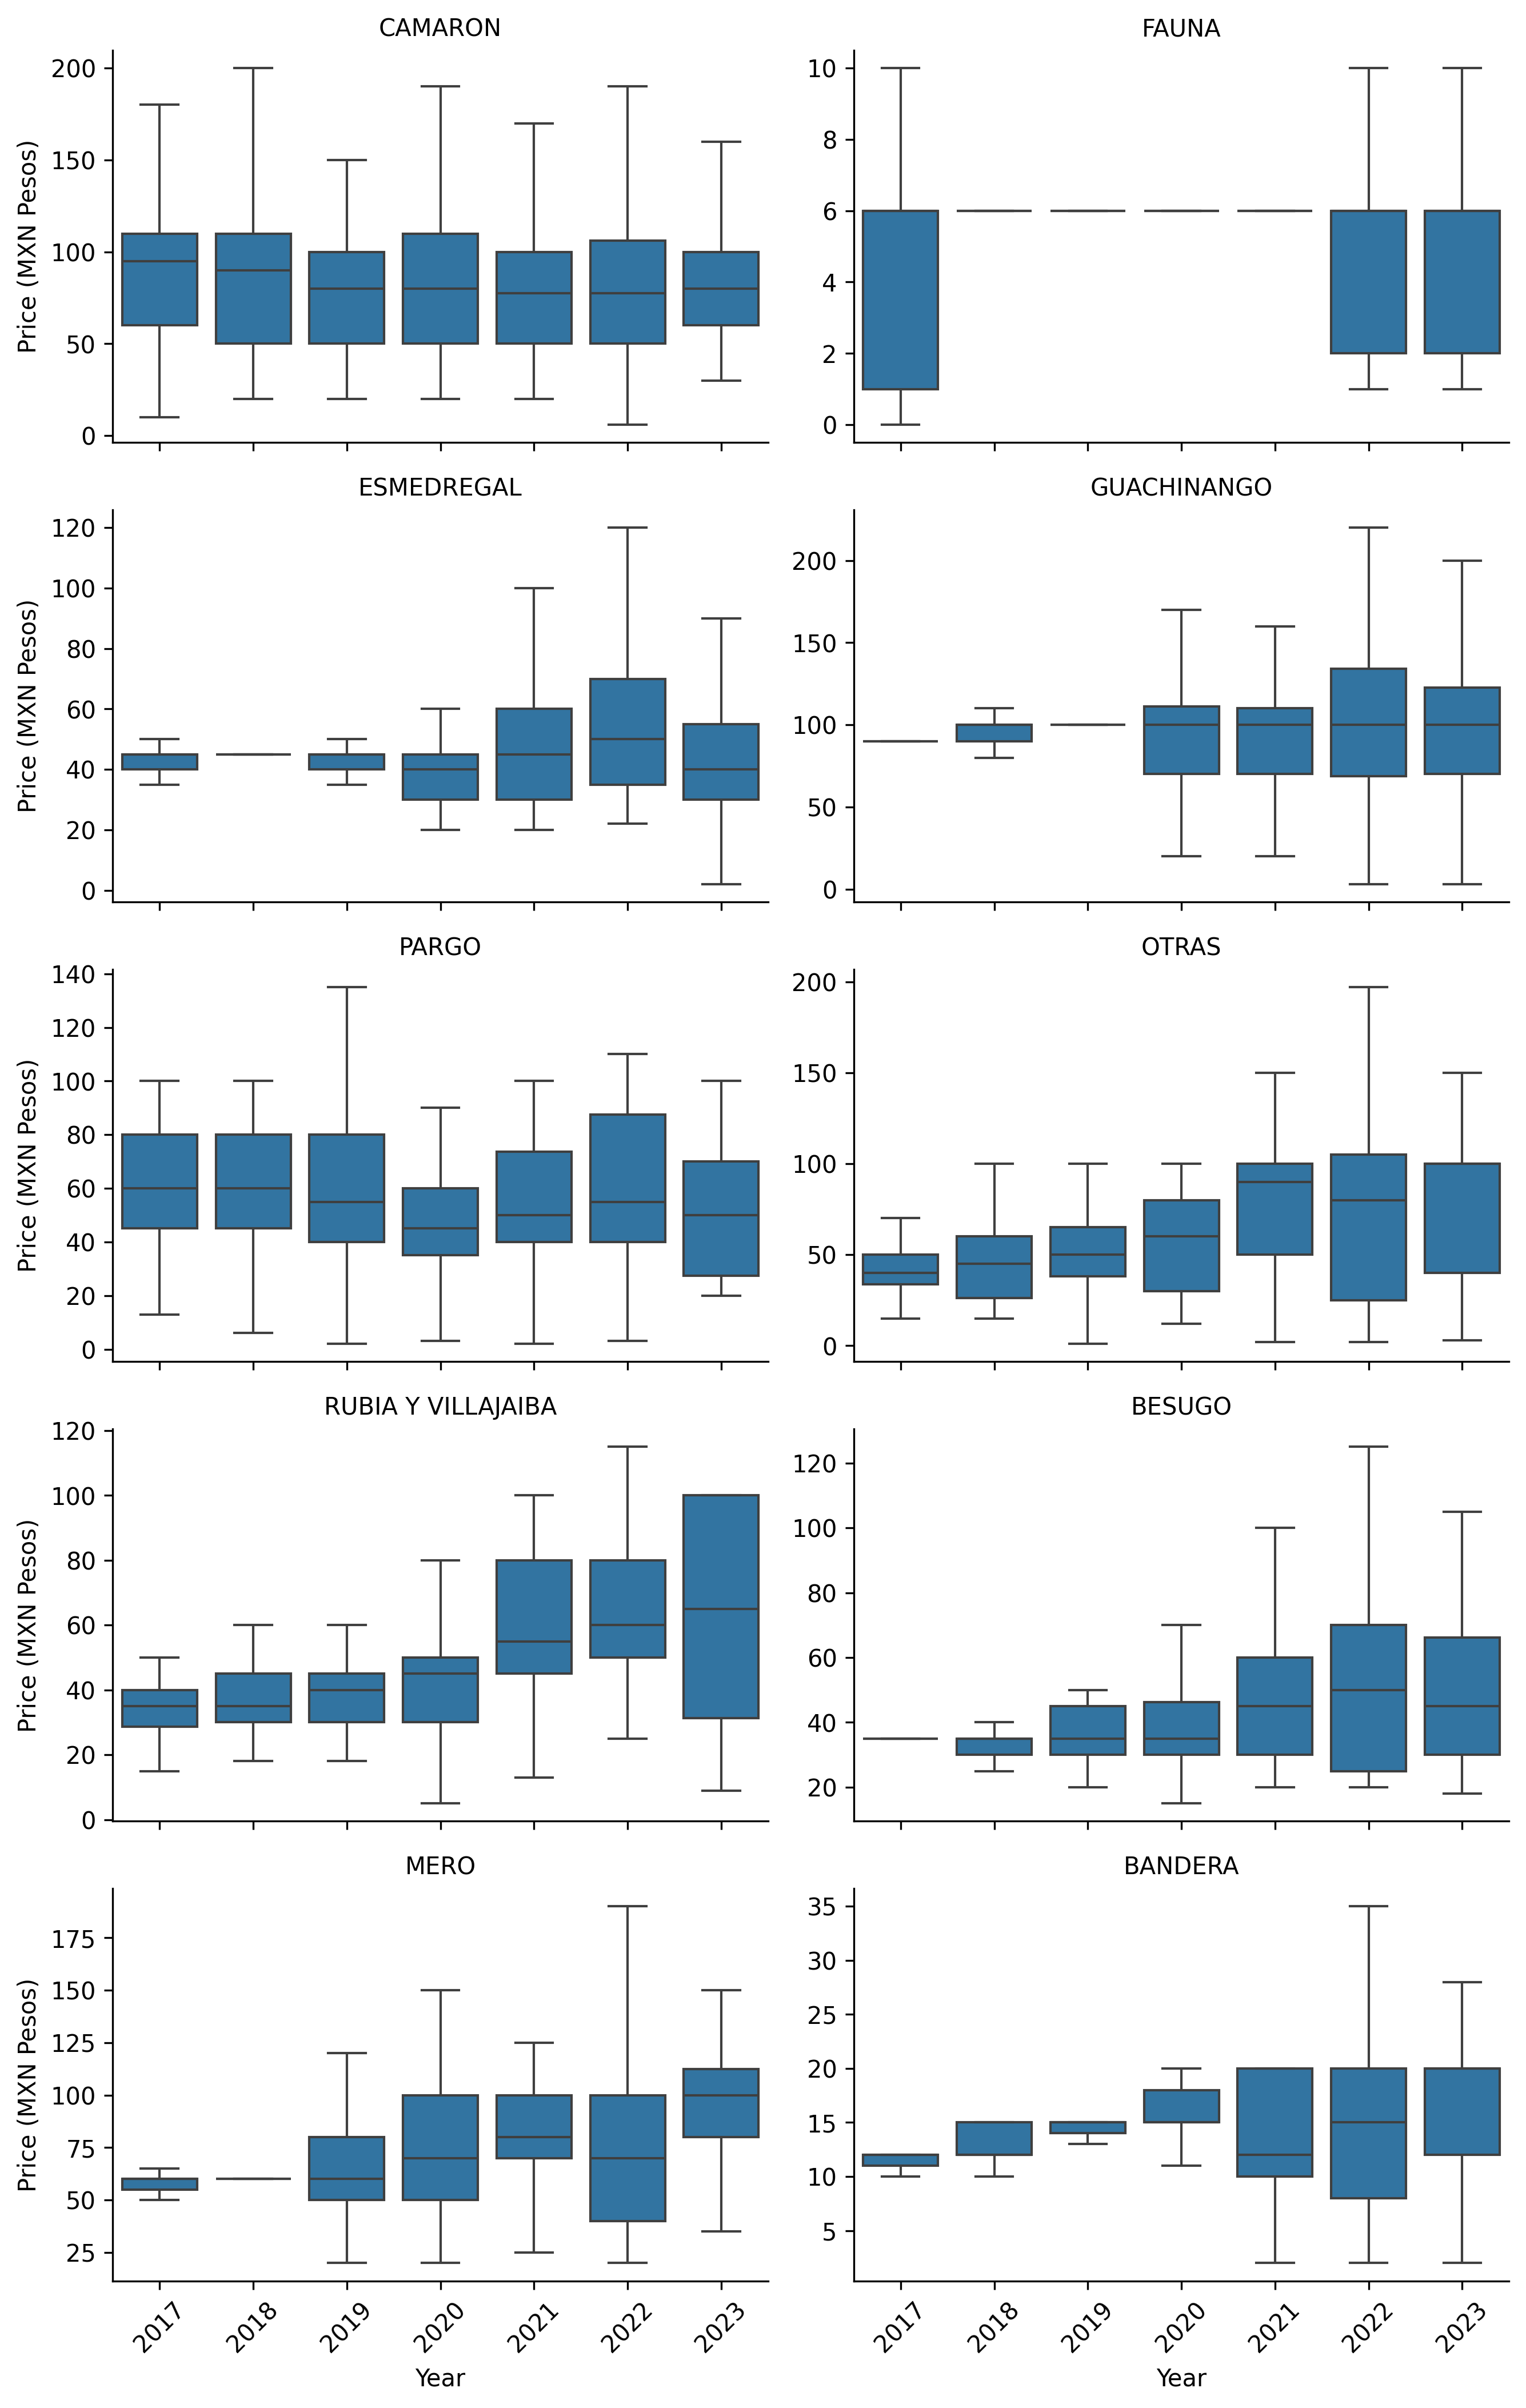

In [16]:
# Filter data for the top 10 species by IIR
top_10_species_df = df[df['NOMBRE PRINCIPAL'].isin(iir_df['NOMBRE PRINCIPAL'].head(10))]

# Create a multi-panel boxplot for annual prices
g = sns.FacetGrid(top_10_species_df, col='NOMBRE PRINCIPAL', col_wrap=2, height=3, aspect=1.5, sharey=False)
g.map_dataframe(sns.boxplot, x='YEAR', y='PRECIO_PESOS', showfliers=False)
g.set_titles('{col_name}')
g.set_axis_labels('Year', 'Price (MXN Pesos)')
for ax in g.axes.flatten():
    for label in ax.get_xticklabels():
        label.set_rotation(45)
g.fig.tight_layout(w_pad=1)  # Adjust layout

# Add a main title
plt.subplots_adjust(top=0.92)
#g.fig.suptitle('b)')
plt.gcf().set_dpi(300)
plt.show()

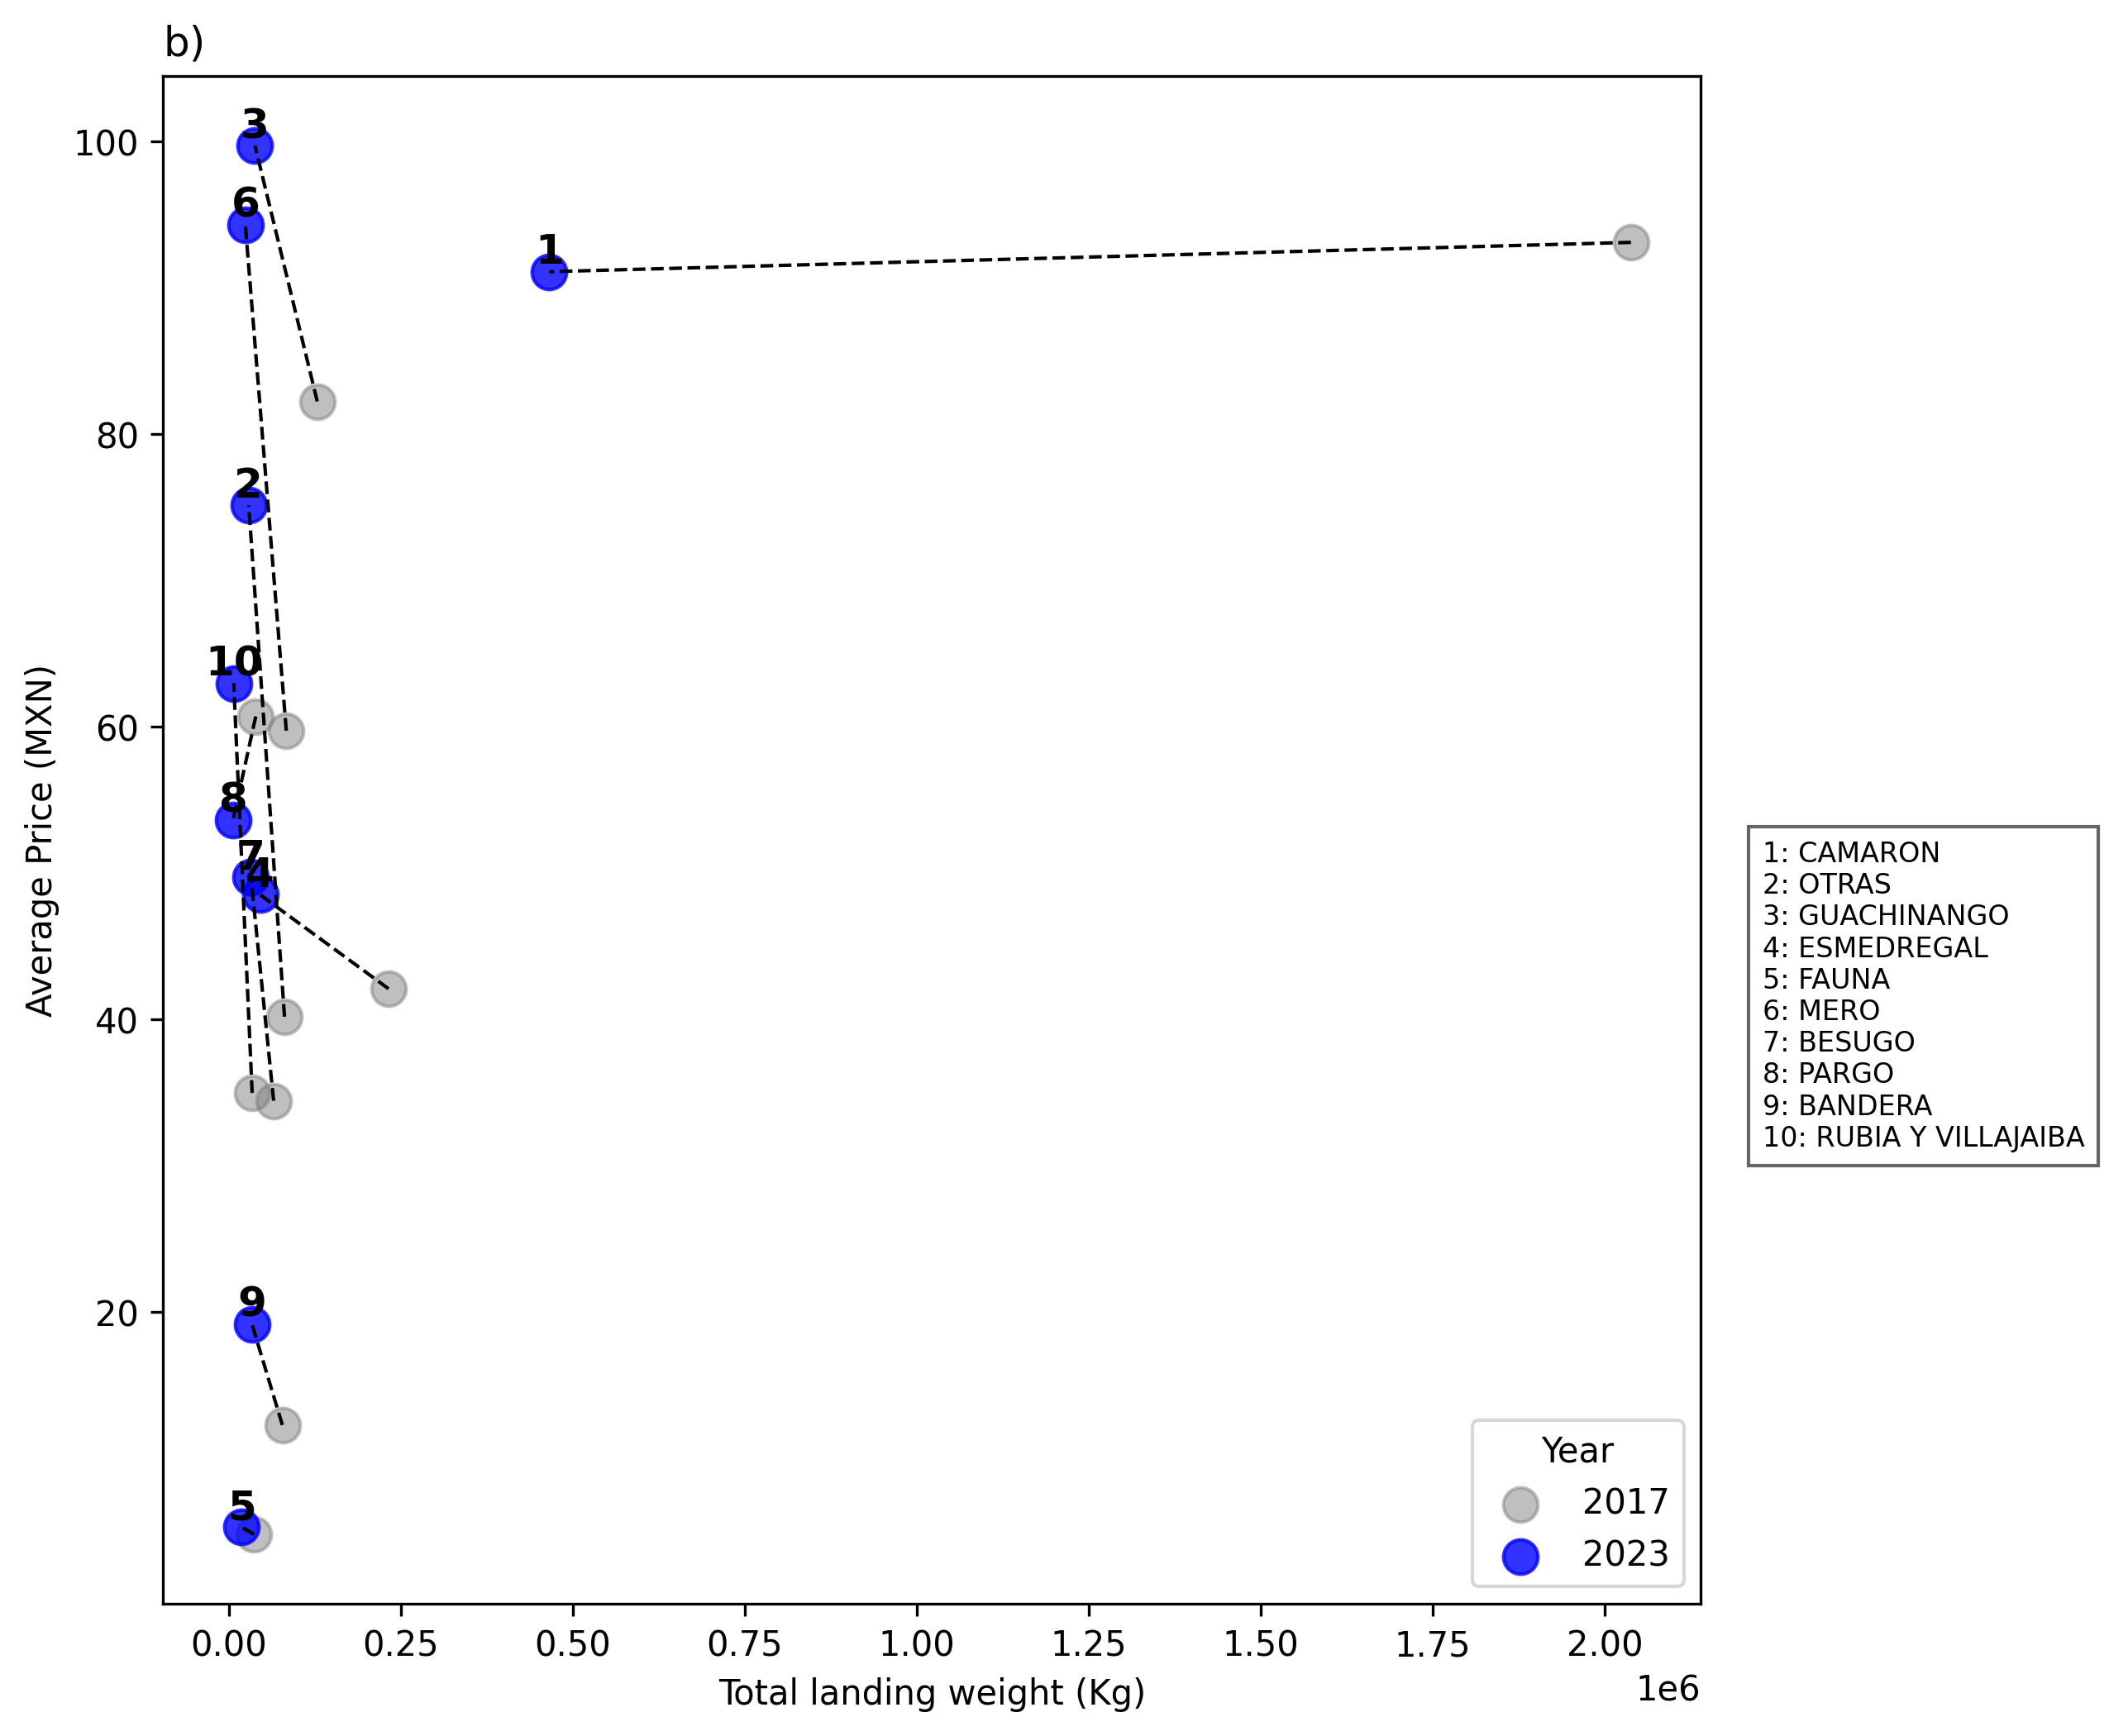

In [14]:
# Calculate IIR for all species
species_summary = df.groupby('NOMBRE PRINCIPAL').agg({
    'PESO DESEMBARCADO_KILOGRAMOS': 'sum',
    'PRECIO_PESOS': 'mean',
    'NOMBRE PRINCIPAL': 'count'
}).rename(columns={
    'PESO DESEMBARCADO_KILOGRAMOS': 'Total Peso Desembarcado (KG)',
    'PRECIO_PESOS': 'Precio Promedio (MXN)',
    'NOMBRE PRINCIPAL': 'Frecuencia de Registro'
}).reset_index()

# Calculate IIR
percent_volume = (species_summary['Total Peso Desembarcado (KG)'] / species_summary['Total Peso Desembarcado (KG)'].sum()) * 100
percent_value = (species_summary['Precio Promedio (MXN)'] / species_summary['Precio Promedio (MXN)'].sum()) * 100
percent_frequency = (species_summary['Frecuencia de Registro'] / species_summary['Frecuencia de Registro'].sum()) * 100
species_summary['IIR'] = (percent_volume + percent_value + percent_frequency) / 3

# Filter top 10 species by IIR and assign labels 1 to 10
top_species_summary = species_summary.nlargest(10, 'IIR').reset_index(drop=True)
top_species_summary['Label'] = range(1, 11)

# Extract data for the years 2017 and 2023
data_2017 = df[(df['YEAR'] == 2017) & (df['NOMBRE PRINCIPAL'].isin(top_species_summary['NOMBRE PRINCIPAL']))]
data_2023 = df[(df['YEAR'] == 2023) & (df['NOMBRE PRINCIPAL'].isin(top_species_summary['NOMBRE PRINCIPAL']))]

# Calculate summary statistics for 2017 and 2023
summary_2017 = data_2017.groupby('NOMBRE PRINCIPAL').agg({
    'PESO DESEMBARCADO_KILOGRAMOS': 'sum',
    'PRECIO_PESOS': 'mean'
}).rename(columns={
    'PESO DESEMBARCADO_KILOGRAMOS': 'Total Peso Desembarcado (KG) 2017',
    'PRECIO_PESOS': 'Precio Promedio (MXN) 2017'
}).reset_index()

summary_2023 = data_2023.groupby('NOMBRE PRINCIPAL').agg({
    'PESO DESEMBARCADO_KILOGRAMOS': 'sum',
    'PRECIO_PESOS': 'mean'
}).rename(columns={
    'PESO DESEMBARCADO_KILOGRAMOS': 'Total Peso Desembarcado (KG) 2023',
    'PRECIO_PESOS': 'Precio Promedio (MXN) 2023'
}).reset_index()

# Merge 2017 and 2023 summaries
merged_summary = pd.merge(summary_2017, summary_2023, on='NOMBRE PRINCIPAL', suffixes=('_2017', '_2023'))
merged_summary = pd.merge(merged_summary, top_species_summary[['NOMBRE PRINCIPAL', 'Label']], on='NOMBRE PRINCIPAL')

# Plotting
plt.figure(figsize=(8, 8), dpi=300)

# Plot data points and lines for top 10 species
for i, row in merged_summary.iterrows():
    plt.scatter(row['Total Peso Desembarcado (KG) 2017'], row['Precio Promedio (MXN) 2017'], color='gray', alpha=0.5, marker='o', s=100, label='2017' if i == 0 else "")
    plt.scatter(row['Total Peso Desembarcado (KG) 2023'], row['Precio Promedio (MXN) 2023'], color='blue', alpha=0.8, marker='o', s=100, label='2023' if i == 0 else "")
    plt.plot([row['Total Peso Desembarcado (KG) 2017'], row['Total Peso Desembarcado (KG) 2023']], 
             [row['Precio Promedio (MXN) 2017'], row['Precio Promedio (MXN) 2023']], 
             'k--', lw=1)
    plt.text(row['Total Peso Desembarcado (KG) 2023'], row['Precio Promedio (MXN) 2023'], str(row['Label']),
             fontsize=12, ha='center', va='bottom', color='black', fontweight='bold')

# Add legend for years
plt.legend(title="Year", loc="lower right")

# Add species list with codes as a legend
legend_text = "\n".join([f"{row['Label']}: {row['NOMBRE PRINCIPAL']}" for i, row in top_species_summary.iterrows()])
plt.gca().text(1.04, 0.5, legend_text, transform=plt.gca().transAxes, fontsize=8, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.6))

# Add labels and title
plt.xlabel('Total landing weight (Kg)')
plt.ylabel('Average Price (MXN)')
plt.title('b)',loc='left')
plt.show()